In [107]:
import os
import sys
sys.path.append(os.path.join('D:', os.sep, 'Users', 'Julien', 'Documents', 'GitHub', 'diploma_thesis', 'cnn'))
import numpy as np
import matplotlib.pyplot as plt
import torch
print(f'Torch version: {torch.__version__}')
from collections import namedtuple
Genotype = namedtuple("Genotype", "normal normal_concat reduce reduce_concat")
from datetime import timedelta
from matplotlib.ticker import MultipleLocator
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from visualize import plot as plot_cells

Torch version: 1.7.1


# Constants

In [108]:
gpu = "v100"
seeds = [1124, 2554, 3141, 5520, 7478]
modes = ["search", "same", "const"]
main_dir = os.path.join('D:', os.sep, 'DA_Results')
os.path.isdir(main_dir)

True

# Load Checkpoints

In [109]:
checkpoints_search = {seed: torch.load(os.path.join(main_dir, 'exp_1_data-shuffle_false', gpu, 'grid_search-batch_size_256', f'search_phase_seed_{seed}', 'outer_loop.ckpt')) for seed in seeds}
checkpoints_eval_psi_same = {seed: torch.load(os.path.join(main_dir, 'exp_1_data-shuffle_false', gpu, 'grid_search-batch_size_256', f'evaluation_phase_seed_{seed}', 'outer_loop.ckpt')) for seed in seeds}
checkpoints_eval_psi_const = {seed: torch.load(os.path.join(main_dir, 'exp_1_data-shuffle_false_constant_channels', gpu, 'grid_search-batch_size_256', f'evaluation_phase_seed_{seed}', 'outer_loop.ckpt')) for seed in seeds}
all_checkpoints = [checkpoints_search, checkpoints_eval_psi_same, checkpoints_eval_psi_const]

evaluation_channels_searched = \
    sorted([int(os.listdir(os.path.join(main_dir, 'exp_1_eval_search'))[i].split('_')[3]) for i in range(len(os.listdir(os.path.join(main_dir, 'exp_1_eval_search'))))])

ckpts_eval = {
    eval_channels: {
        seed: torch.load(os.path.join(main_dir, 'exp_1_eval_search', f'exp_1_eval_{eval_channels}', f'evaluation_phase_seed_{seed}', 'outer_loop.ckpt'))
        for seed in seeds
    }
    for eval_channels in evaluation_channels_searched  
}

init_channels_searched = []
for ckpt in all_checkpoints:
    for seed in seeds:
        channels = []
        for init_channels, values in ckpt[seed]['history'].items():
            if any(['error' in x for x in values.keys()]):
                continue
            else:
                channels.append(init_channels)
                
        init_channels_searched.append(channels)
        
assert init_channels_searched.count(init_channels_searched[0]) == len(init_channels_searched), "Different channels evaluated"
init_channels_searched = init_channels_searched[0]
print(f"Searched initial channels: {init_channels_searched}")
print(f"Searched evaluation channels: {evaluation_channels_searched}")

Searched initial channels: [4, 8, 12, 16, 20, 24, 28, 32, 36]
Searched evaluation channels: [4, 12, 24, 36, 48, 60, 72, 84, 96, 108]


# Number of Parameters of Architectures Found With Seed 2554

In [110]:
for zeta in init_channels_searched:
    print(zeta)
    print(f"    {checkpoints_eval_psi_const[2554]['history'][zeta]['max_mem_allocated_MB']}")

4
    13463.67744
8
    11926.55872
12
    11805.3248
16
    14404.9792
20
    12546.70592
24
    9603.131904
28
    8695.584256
32
    11191.960576
36
    9036.261376


# Load and parse TensorBoard logs

In [111]:
tb_logs = {
    mode: {
        seed: {
            zeta: os.path.join(
                main_dir, 
                f"exp_1_data-shuffle_false{'_constant_channels' if mode == 'const' else ''}",
                "v100", "grid_search-batch_size_256",
                f"{'search' if mode == 'search' else 'evaluation'}_phase_seed_{seed}",
                "tensorboard",
                f"init_channels_{zeta}"
            ) for zeta in init_channels_searched
        } 
        for seed in seeds
    } 
    for mode in modes
}

train_details = {
    mode: {
        seed:{
            zeta: {}
            for zeta in init_channels_searched
        }
        for seed in seeds
    }
    for mode in modes
}

for mode in modes:
    print(f"Mode: {mode}")
    for seed in seeds:
        print(f"    Seed {seed}")
        for zeta in init_channels_searched:
            print(f"        Zeta = {zeta}")
            event_accumulator = EventAccumulator(tb_logs[mode][seed][zeta]).Reload()
            for metric in ["Loss/train", "Loss/valid", "Top1/train", "Top1/valid", "Top5/train", 
                           "Top5/valid", "lr", "Mem/peak_allocated_MB", "Mem/peak_reserved_MB"]:
                train_details[mode][seed][zeta][metric] = np.asarray(
                    [getattr(entry, 'value') for entry in event_accumulator.Scalars(metric)]
                )

Mode: search
    Seed 1124
        Zeta = 4
        Zeta = 8
        Zeta = 12
        Zeta = 16
        Zeta = 20
        Zeta = 24
        Zeta = 28
        Zeta = 32
        Zeta = 36
    Seed 2554
        Zeta = 4
        Zeta = 8
        Zeta = 12
        Zeta = 16
        Zeta = 20
        Zeta = 24
        Zeta = 28
        Zeta = 32
        Zeta = 36
    Seed 3141
        Zeta = 4
        Zeta = 8
        Zeta = 12
        Zeta = 16
        Zeta = 20
        Zeta = 24
        Zeta = 28
        Zeta = 32
        Zeta = 36
    Seed 5520
        Zeta = 4
        Zeta = 8
        Zeta = 12
        Zeta = 16
        Zeta = 20
        Zeta = 24
        Zeta = 28
        Zeta = 32
        Zeta = 36
    Seed 7478
        Zeta = 4
        Zeta = 8
        Zeta = 12
        Zeta = 16
        Zeta = 20
        Zeta = 24
        Zeta = 28
        Zeta = 32
        Zeta = 36
Mode: same
    Seed 1124
        Zeta = 4
        Zeta = 8
        Zeta = 12
        Zeta = 16
        Zeta = 20
    

# Variables to store the parsed checkpoints

In [112]:
results_averaged = {x: {} for x in modes} # used for tables
eval_phases_averaged = {zeta: {
    metric: {}
    for metric in ["train", "valid", "mem", "runtime", "params"]
} for zeta in evaluation_channels_searched}
plot_arrays = {x: {} for x in modes} # used for plots

# Parse checkpoints and average

In [113]:
for i, ckpt in enumerate(all_checkpoints):
    search = False
    if i == 0:
        search = True
    # for mean / std calculation
    all_seeds_train = {channels: [] for channels in init_channels_searched}
    all_seeds_valid = {channels: [] for channels in init_channels_searched}
    all_seeds_runtime = {channels: [] for channels in init_channels_searched}
    all_seeds_mem = {channels: [] for channels in init_channels_searched}
    if not search:
        all_seeds_parameters = {channels: [] for channels in init_channels_searched}

    for seed in seeds: 
        for init_channels in init_channels_searched:
            vals = ckpt[seed]['history'][init_channels]
            all_seeds_train[init_channels].append(vals['search_train_acc'] if search else vals['train_acc'])
            all_seeds_valid[init_channels].append(vals['search_valid_acc'] if search else vals['valid_acc'])
            all_seeds_runtime[init_channels].append(vals['overall_search_time'] if search else vals['overall_eval_time'])
            all_seeds_mem[init_channels].append(vals['max_mem_allocated_MB'])
            if not search:
                all_seeds_parameters[init_channels].append(vals['model_parameters'])

    for init_channels in init_channels_searched:
        train = np.asarray(all_seeds_train[init_channels])
        valid = np.asarray(all_seeds_valid[init_channels])
        runtime = np.asarray(all_seeds_runtime[init_channels])
        mem = np.asarray(all_seeds_mem[init_channels])
        if not search:
            parameters = np.asarray(all_seeds_parameters[init_channels])

        # Average --> mean / std
        results_averaged[list(results_averaged.keys())[i]][init_channels] = {
            'train': {
                'mean': np.mean(train),
                'std': np.std(train)
            },
            'valid': {
                'mean': np.mean(valid),
                'std': np.std(valid)
            },
            'mem': {
                'mean': np.mean(mem),
                'std': np.std(mem)
            },
            'runtime': {
                'mean': str(timedelta(seconds=np.mean(runtime))).split('.')[0],
                'std': str(timedelta(seconds=np.std(runtime))).split('.')[0]
            },
            'runtime_raw': {
                'mean': np.mean(runtime),
                'std': np.std(runtime)
            }
        }
        if not search:
            results_averaged[list(results_averaged.keys())[i]][init_channels]['parameters'] = {
                'mean': np.mean(parameters),
                'std': np.std(parameters)
            }
            
# create numpy arrays for plots
for mode in modes:
    for metric in ["train", "valid", "mem", "runtime_raw", "parameters"]:
        if mode == "search" and metric == "parameters":
            continue
        if not metric in plot_arrays[mode].keys():
            plot_arrays[mode][metric] = {}
        for dist in ['mean', 'std']:
            plot_arrays[mode][metric][dist] = np.asarray([results_averaged[mode][zeta][metric][dist] for zeta in init_channels_searched])
            
# average evaluation checkpoints
for zeta in evaluation_channels_searched:
    mets = {
        m: []
        for m in ["train", "valid", "mem", "runtime", "params"]
    }
    
    for seed in seeds:
        if any("error" in key for key in ckpts_eval[zeta][seed]['history'][24].keys()):
            continue
        mets['train'].append(ckpts_eval[zeta][seed]['history'][24]["train_acc"])
        mets['valid'].append(ckpts_eval[zeta][seed]['history'][24]["valid_acc"])
        mets['mem'].append(ckpts_eval[zeta][seed]['history'][24]['max_mem_allocated_MB'])
        mets['runtime'].append(ckpts_eval[zeta][seed]['history'][24]['overall_eval_time'])
        mets['params'].append(ckpts_eval[zeta][seed]['history'][24]['model_parameters'])
    
    for metric in ["train", "valid", "mem", "runtime", "params"]:
        eval_phases_averaged[zeta][metric]['mean'] = np.mean(mets[metric])
        eval_phases_averaged[zeta][metric]['std'] = np.std(mets[metric])

In [57]:
eval_phases_averaged[96]

{'train': {'mean': 99.94625473022461, 'std': 0.008005168343047583},
 'valid': {'mean': 96.67316818237305, 'std': 0.09521292423184098},
 'mem': {'mean': 25920.36224, 'std': 420.0291500088369},
 'runtime': {'mean': 34434.42482649148, 'std': 1058.4964473170378},
 'params': {'mean': 20027892.0, 'std': 257290.56694717746}}

# Latex average table for search phase

In [8]:
bottomrule = " \\bottomrule"
print("$\zeta_\mathrm{search}$ & Runtime (h:mm:ss) & $\\text{GPU Mem (MiB)}^\dagger$ & train\_error (\%) & valid\_error (\%) \\\\ \midrule")
for i, init_channels in enumerate(init_channels_searched):
    print(
        f"& ${init_channels}$ & N/A & "
        f"${results_averaged['search'][init_channels]['runtime']['mean']} \\pm {results_averaged['search'][init_channels]['runtime']['std']}$ & "
        f"${round(results_averaged['search'][init_channels]['mem']['mean'], 2)} \\pm {round(results_averaged['search'][init_channels]['mem']['std'], 2)}$ & N/A & "
        f"${round(100 - results_averaged['search'][init_channels]['train']['mean'], 2)} \\pm {round(results_averaged['search'][init_channels]['train']['std'], 2)}$ & "
        f"${round(100 - results_averaged['search'][init_channels]['valid']['mean'], 2)} \\pm {round(results_averaged['search'][init_channels]['valid']['std'], 2)}$ \\\\"
        f"{bottomrule if i == len(init_channels_searched)-1 else ''}"
    )

$\zeta_\mathrm{search}$ & Runtime (h:mm:ss) & $\text{GPU Mem (MiB)}^\dagger$ & train\_error (\%) & valid\_error (\%) \\ \midrule
& $4$ & N/A & $6:18:09 \pm 0:16:03$ & $2900.58 \pm 0.0$ & N/A & $24.46 \pm 1.01$ & $26.58 \pm 1.09$ \\
& $8$ & N/A & $3:24:33 \pm 0:07:16$ & $5715.9 \pm 2.87$ & N/A & $15.5 \pm 1.01$ & $20.0 \pm 0.74$ \\
& $12$ & N/A & $3:32:24 \pm 0:06:13$ & $8665.62 \pm 2.69$ & N/A & $11.0 \pm 0.22$ & $17.29 \pm 0.28$ \\
& $16$ & N/A & $3:35:21 \pm 0:00:57$ & $11339.04 \pm 3.17$ & N/A & $8.66 \pm 0.26$ & $15.81 \pm 0.37$ \\
& $20$ & N/A & $3:43:51 \pm 0:02:45$ & $14170.99 \pm 0.7$ & N/A & $7.07 \pm 0.21$ & $15.18 \pm 0.18$ \\
& $24$ & N/A & $3:48:55 \pm 0:01:40$ & $17225.49 \pm 8.18$ & N/A & $6.16 \pm 0.51$ & $14.76 \pm 0.4$ \\
& $28$ & N/A & $3:54:05 \pm 0:00:32$ & $20263.51 \pm 4.98$ & N/A & $5.21 \pm 0.21$ & $14.48 \pm 0.3$ \\
& $32$ & N/A & $3:59:46 \pm 0:02:18$ & $22603.51 \pm 0.7$ & N/A & $4.6 \pm 0.36$ & $14.22 \pm 0.24$ \\
& $36$ & N/A & $4:07:34 \pm 0:01:17$ & $254

# Latex average table for $\Psi_\mathrm{same}$ and $\Psi_\mathrm{const}$

In [10]:
midrule = " \midrule"
bottomrule = " \\bottomrule"
print("$\zeta_\mathrm{search}$ & $\zeta_\mathrm{eval}$ & Runtime (h:mm:ss) & $\\text{GPU Mem (MiB)}^\dagger$ & Parameters (M)& train\_error (\%) & valid\_error (\%) \\\\ \midrule")
for Psi in ["same", "const"]:
    for i, init_channels in enumerate(init_channels_searched):
        print(
            f"& ${init_channels}$ & ${init_channels if Psi == 'same' else 36}$ & "
            f"${results_averaged[Psi][init_channels]['runtime']['mean']} \\pm {results_averaged[Psi][init_channels]['runtime']['std']}$ & "
            f"${round(results_averaged[Psi][init_channels]['mem']['mean'], 2)} \\pm {round(results_averaged[Psi][init_channels]['mem']['std'], 2)}$ & "
            f"${round(results_averaged[Psi][init_channels]['parameters']['mean']/1e6, 3)} \\pm {round(results_averaged[Psi][init_channels]['parameters']['std']/1e6, 3)}$ & "
            f"${round(100 - results_averaged[Psi][init_channels]['train']['mean'], 2)} \\pm {round(results_averaged[Psi][init_channels]['train']['std'], 2)}$ & "
            f"${round(100 - results_averaged[Psi][init_channels]['valid']['mean'], 2)} \\pm {round(results_averaged[Psi][init_channels]['valid']['std'], 2)}$ \\\\"
            f"{midrule if (i == len(init_channels_searched)-1) and (Psi == 'same') else ''}{bottomrule if (i == len(init_channels_searched)-1) and (Psi == 'const') else ''}"
        )

$\zeta_\mathrm{search}$ & $\zeta_\mathrm{eval}$ & Runtime (h:mm:ss) & $\text{GPU Mem (MiB)}^\dagger$ & Parameters (M)& train\_error (\%) & valid\_error (\%) \\ \midrule
& $4$ & $4$ & $9:08:02 \pm 0:54:53$ & $1382.15 \pm 125.94$ & $0.499 \pm 0.007$ & $6.04 \pm 1.42$ & $7.92 \pm 0.97$ \\
& $8$ & $8$ & $8:11:34 \pm 1:03:06$ & $2519.67 \pm 330.78$ & $0.642 \pm 0.027$ & $2.42 \pm 0.36$ & $6.31 \pm 0.3$ \\
& $12$ & $12$ & $8:54:22 \pm 1:30:13$ & $4158.42 \pm 596.3$ & $0.893 \pm 0.06$ & $0.95 \pm 0.34$ & $4.99 \pm 0.39$ \\
& $16$ & $16$ & $8:40:29 \pm 1:41:06$ & $5108.71 \pm 697.58$ & $1.167 \pm 0.088$ & $0.78 \pm 0.3$ & $4.74 \pm 0.33$ \\
& $20$ & $20$ & $8:52:10 \pm 0:37:33$ & $6445.07 \pm 422.24$ & $1.589 \pm 0.084$ & $0.51 \pm 0.36$ & $4.44 \pm 0.34$ \\
& $24$ & $24$ & $7:30:57 \pm 0:52:12$ & $6754.9 \pm 652.04$ & $1.841 \pm 0.152$ & $0.32 \pm 0.14$ & $3.94 \pm 0.13$ \\
& $28$ & $28$ & $8:02:28 \pm 2:06:23$ & $8509.68 \pm 1870.82$ & $2.412 \pm 0.439$ & $0.26 \pm 0.07$ & $4.06 \pm 0.24$ \\

# Latex table for different $\zeta_\mathrm{eval}$ for a fixed $\zeta_\mathrm{search}$

In [59]:
eval_phases_averaged[4]

{'train': {'mean': 92.0249038696289, 'std': 0.8625977712215691},
 'valid': {'mean': 91.26974487304688, 'std': 0.28611914558124457},
 'mem': {'mean': 1134.9352448, 'std': 107.97715580586694},
 'runtime': {'mean': 25985.784620629063, 'std': 2986.4660810523023},
 'params': {'mean': 471392.0, 'std': 11231.116774390694}}

In [62]:
midrule = " \midrule"
bottomrule = " \\bottomrule"
print(
    "$\zeta_\mathrm{search}$ & $\zeta_\mathrm{eval}$ & "
    "Runtime (h:mm:ss)$^\dagger$ & $\\text{GPU Mem (MiB)}^\ddagger$ & Parameters (M) & train\_error (\%) & valid\_error (\%) \\\\ \midrule"
)
for index, eval_channel in enumerate(evaluation_channels_searched):
    print(
        f"& $24$ & ${eval_channel}$ & "
        f"${str(timedelta(seconds=eval_phases_averaged[eval_channel]['runtime']['mean'])).split('.')[0]} \\pm {str(timedelta(seconds=eval_phases_averaged[eval_channel]['runtime']['std'])).split('.')[0]}$ & "
        f"${round(eval_phases_averaged[eval_channel]['mem']['mean'], 2)} \\pm {round(eval_phases_averaged[eval_channel]['mem']['std'], 2)}$ & "
        f"${round(eval_phases_averaged[eval_channel]['params']['mean']/1e6, 3)} \\pm {round(eval_phases_averaged[eval_channel]['mem']['std']/1e6, 3)}$ & "
        f"${round(100 - eval_phases_averaged[eval_channel]['train']['mean'], 2)} \\pm {round(eval_phases_averaged[eval_channel]['train']['std'], 2)}$ & "
        f"${round(100 - eval_phases_averaged[eval_channel]['valid']['mean'], 2)} \\pm {round(eval_phases_averaged[eval_channel]['valid']['std'], 2)}$ \\\\"
        f"{bottomrule if index == len(evaluation_channels_searched)-1 else ''}"
    )

$\zeta_\mathrm{search}$ & $\zeta_\mathrm{eval}$ & Runtime (h:mm:ss)$^\dagger$ & $\text{GPU Mem (MiB)}^\ddagger$ & Parameters (M) & train\_error (\%) & valid\_error (\%) \\ \midrule
& $24$ & $4$ & $7:13:05 \pm 0:49:46$ & $1134.94 \pm 107.98$ & $0.471 \pm 0.0$ & $7.98 \pm 0.86$ & $8.73 \pm 0.29$ \\
& $24$ & $12$ & $7:14:41 \pm 0:55:12$ & $3441.29 \pm 334.17$ & $0.814 \pm 0.0$ & $0.99 \pm 0.2$ & $4.83 \pm 0.15$ \\
& $24$ & $24$ & $7:30:57 \pm 0:52:12$ & $6754.9 \pm 652.04$ & $1.841 \pm 0.001$ & $0.32 \pm 0.14$ & $3.94 \pm 0.13$ \\
& $24$ & $36$ & $7:54:33 \pm 1:20:37$ & $10140.49 \pm 979.28$ & $3.485 \pm 0.001$ & $0.16 \pm 0.04$ & $3.69 \pm 0.16$ \\
& $24$ & $48$ & $7:59:22 \pm 1:00:13$ & $13535.66 \pm 1306.98$ & $5.744 \pm 0.001$ & $0.14 \pm 0.03$ & $3.64 \pm 0.19$ \\
& $24$ & $60$ & $8:14:17 \pm 1:06:09$ & $17165.25 \pm 1667.52$ & $8.619 \pm 0.002$ & $0.12 \pm 0.06$ & $3.52 \pm 0.2$ \\
& $24$ & $72$ & $9:02:00 \pm 1:10:29$ & $20366.69 \pm 1965.35$ & $12.11 \pm 0.002$ & $0.09 \pm 0.03$ &

# Plots for search phase

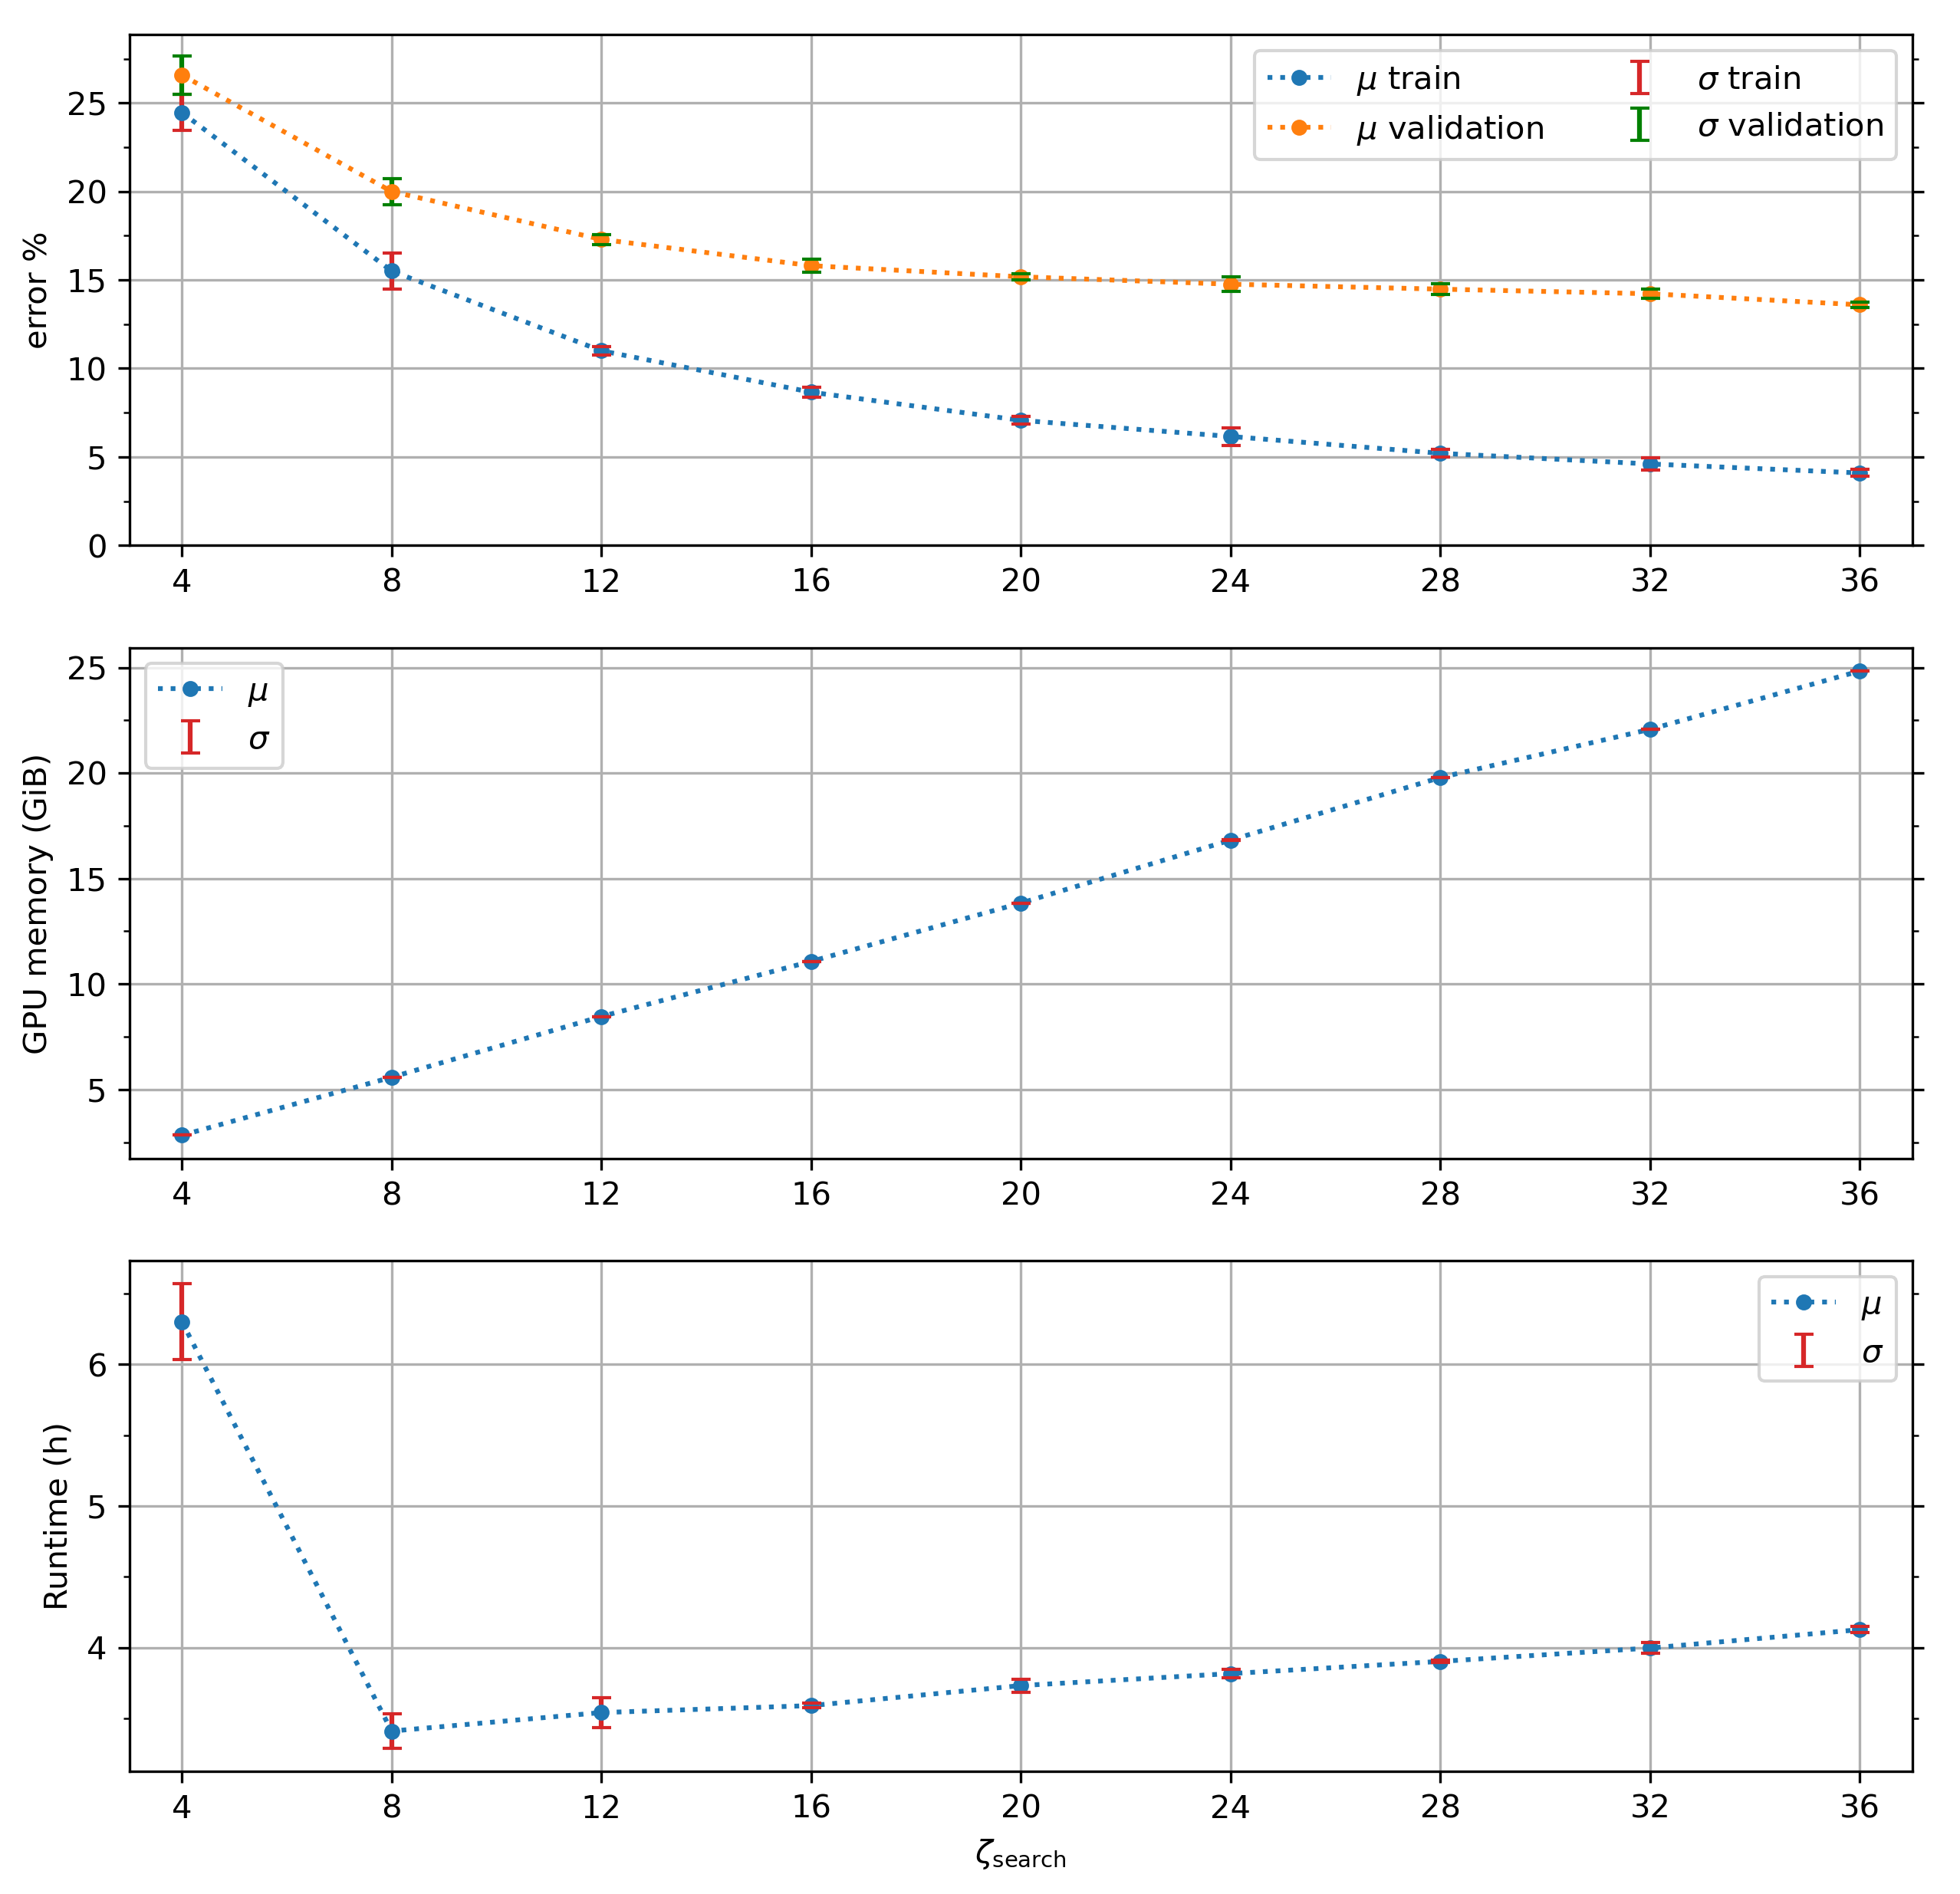

In [122]:
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
fig = plt.figure(figsize=(10, 10), dpi=300)
#fig.suptitle(
#    (
#        "Train and validation error, GPU memory consumption and runtime of\n"
#        r"the search phase for different $\zeta_\mathrm{search}$ over 5 random seeds"
#        f"\non a single NVIDIA {gpu.upper()} GPU"
#    ), y=0.96)
overall = fig.add_subplot(111)
overall.spines['top'].set_color('none')
overall.spines['bottom'].set_color('none')
overall.spines['left'].set_color('none')
overall.spines['right'].set_color('none')
overall.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
overall.set_xlabel(r'$\zeta_\mathrm{search}$')

error = fig.add_subplot(311)
mem = fig.add_subplot(312)
runtime = fig.add_subplot(313)
for ax in fig.get_axes()[1:]:
    ax.yaxis.set_minor_locator(MultipleLocator(2.5))
    ax.grid()
    ax.set_xlim([init_channels_searched[0]-1, init_channels_searched[-1]+1])
    ax.set_xticks(init_channels_searched)
    ax.yaxis.set_ticks_position('both')
runtime.yaxis.set_minor_locator(MultipleLocator(0.5))
    
# plot train and validation error

#error.scatter(
#    init_channels_searched,
#    100 - plot_arrays['search']['train']['mean'],
#    s = 10,
#    marker="o",
#    color="C0"
#)
#error.scatter(
#    init_channels_searched,
#    100 - plot_arrays['search']['valid']['mean'],
#    s=10,
#    marker="o",
#    color="C1"
#)
error.plot(
    init_channels_searched,
    100 - plot_arrays['search']['train']['mean'],
    linestyle="dotted",
    marker="o",
    markersize=4,
    color="C0"
)
error.plot(
    init_channels_searched,
    100 - plot_arrays['search']['valid']['mean'],
    linestyle="dotted",
    marker="o",
    markersize=4,
    color="C1"
)
error.errorbar(
    init_channels_searched, 
    100 - plot_arrays['search']['train']['mean'], 
    plot_arrays['search']['train']['std'],
    fmt="None",
    capsize=3,
    color="C3"
)
error.errorbar(
    init_channels_searched,
    100 - plot_arrays['search']['valid']['mean'],
    plot_arrays['search']['valid']['std'],
    fmt="None",
    capsize=3,
    color="g"
)
error.set_ylabel("error %")
error.legend(
    [r'$\mu$ train', r'$\mu$ validation', r'$\sigma$ train', r'$\sigma$ validation'],
    ncol=2
)

# plot gpu memory consumption

#mem.scatter(
#    init_channels_searched,
#    plot_arrays['search']['mem']['mean']/1024,
#    s=10,
#    marker="o",
#    color="C0"
#)
mem.plot(
    init_channels_searched,
    plot_arrays['search']['mem']['mean']/1024,
    linestyle="dotted",
    marker="o",
    markersize=4,
    color="C0"
)
mem.errorbar(
    init_channels_searched,
    plot_arrays['search']['mem']['mean']/1024,
    plot_arrays['search']['mem']['std']/1024,
    fmt="None",
    capsize=3,
    color="C3"
)
mem.set_ylabel("GPU memory (GiB)")
mem.legend([r'$\mu$', r'$\sigma$'])

# plot runtimes
#runtime.scatter(
#    init_channels_searched,
#    plot_arrays['search']['runtime_raw']['mean']/3600,
#    s=10,
#    marker='o',
#    color="C0"
#)
runtime.plot(
    init_channels_searched,
    plot_arrays['search']['runtime_raw']['mean']/3600,
    linestyle="dotted",
    marker="o",
    markersize=4,
    color="C0"
)
runtime.errorbar(
    init_channels_searched,
    plot_arrays['search']['runtime_raw']['mean']/3600,
    plot_arrays['search']['runtime_raw']['std']/3600,
    fmt='None',
    capsize=3,
    color="C3"
)
runtime.set_ylabel("Runtime (h)")
runtime.legend([r'$\mu$', r'$\sigma$'])

error.set_ylim(bottom=0)

plt.savefig("images/exp_1_search.svg", bbox_inches="tight")

plt.show()

# Plots for evaluation phases

same


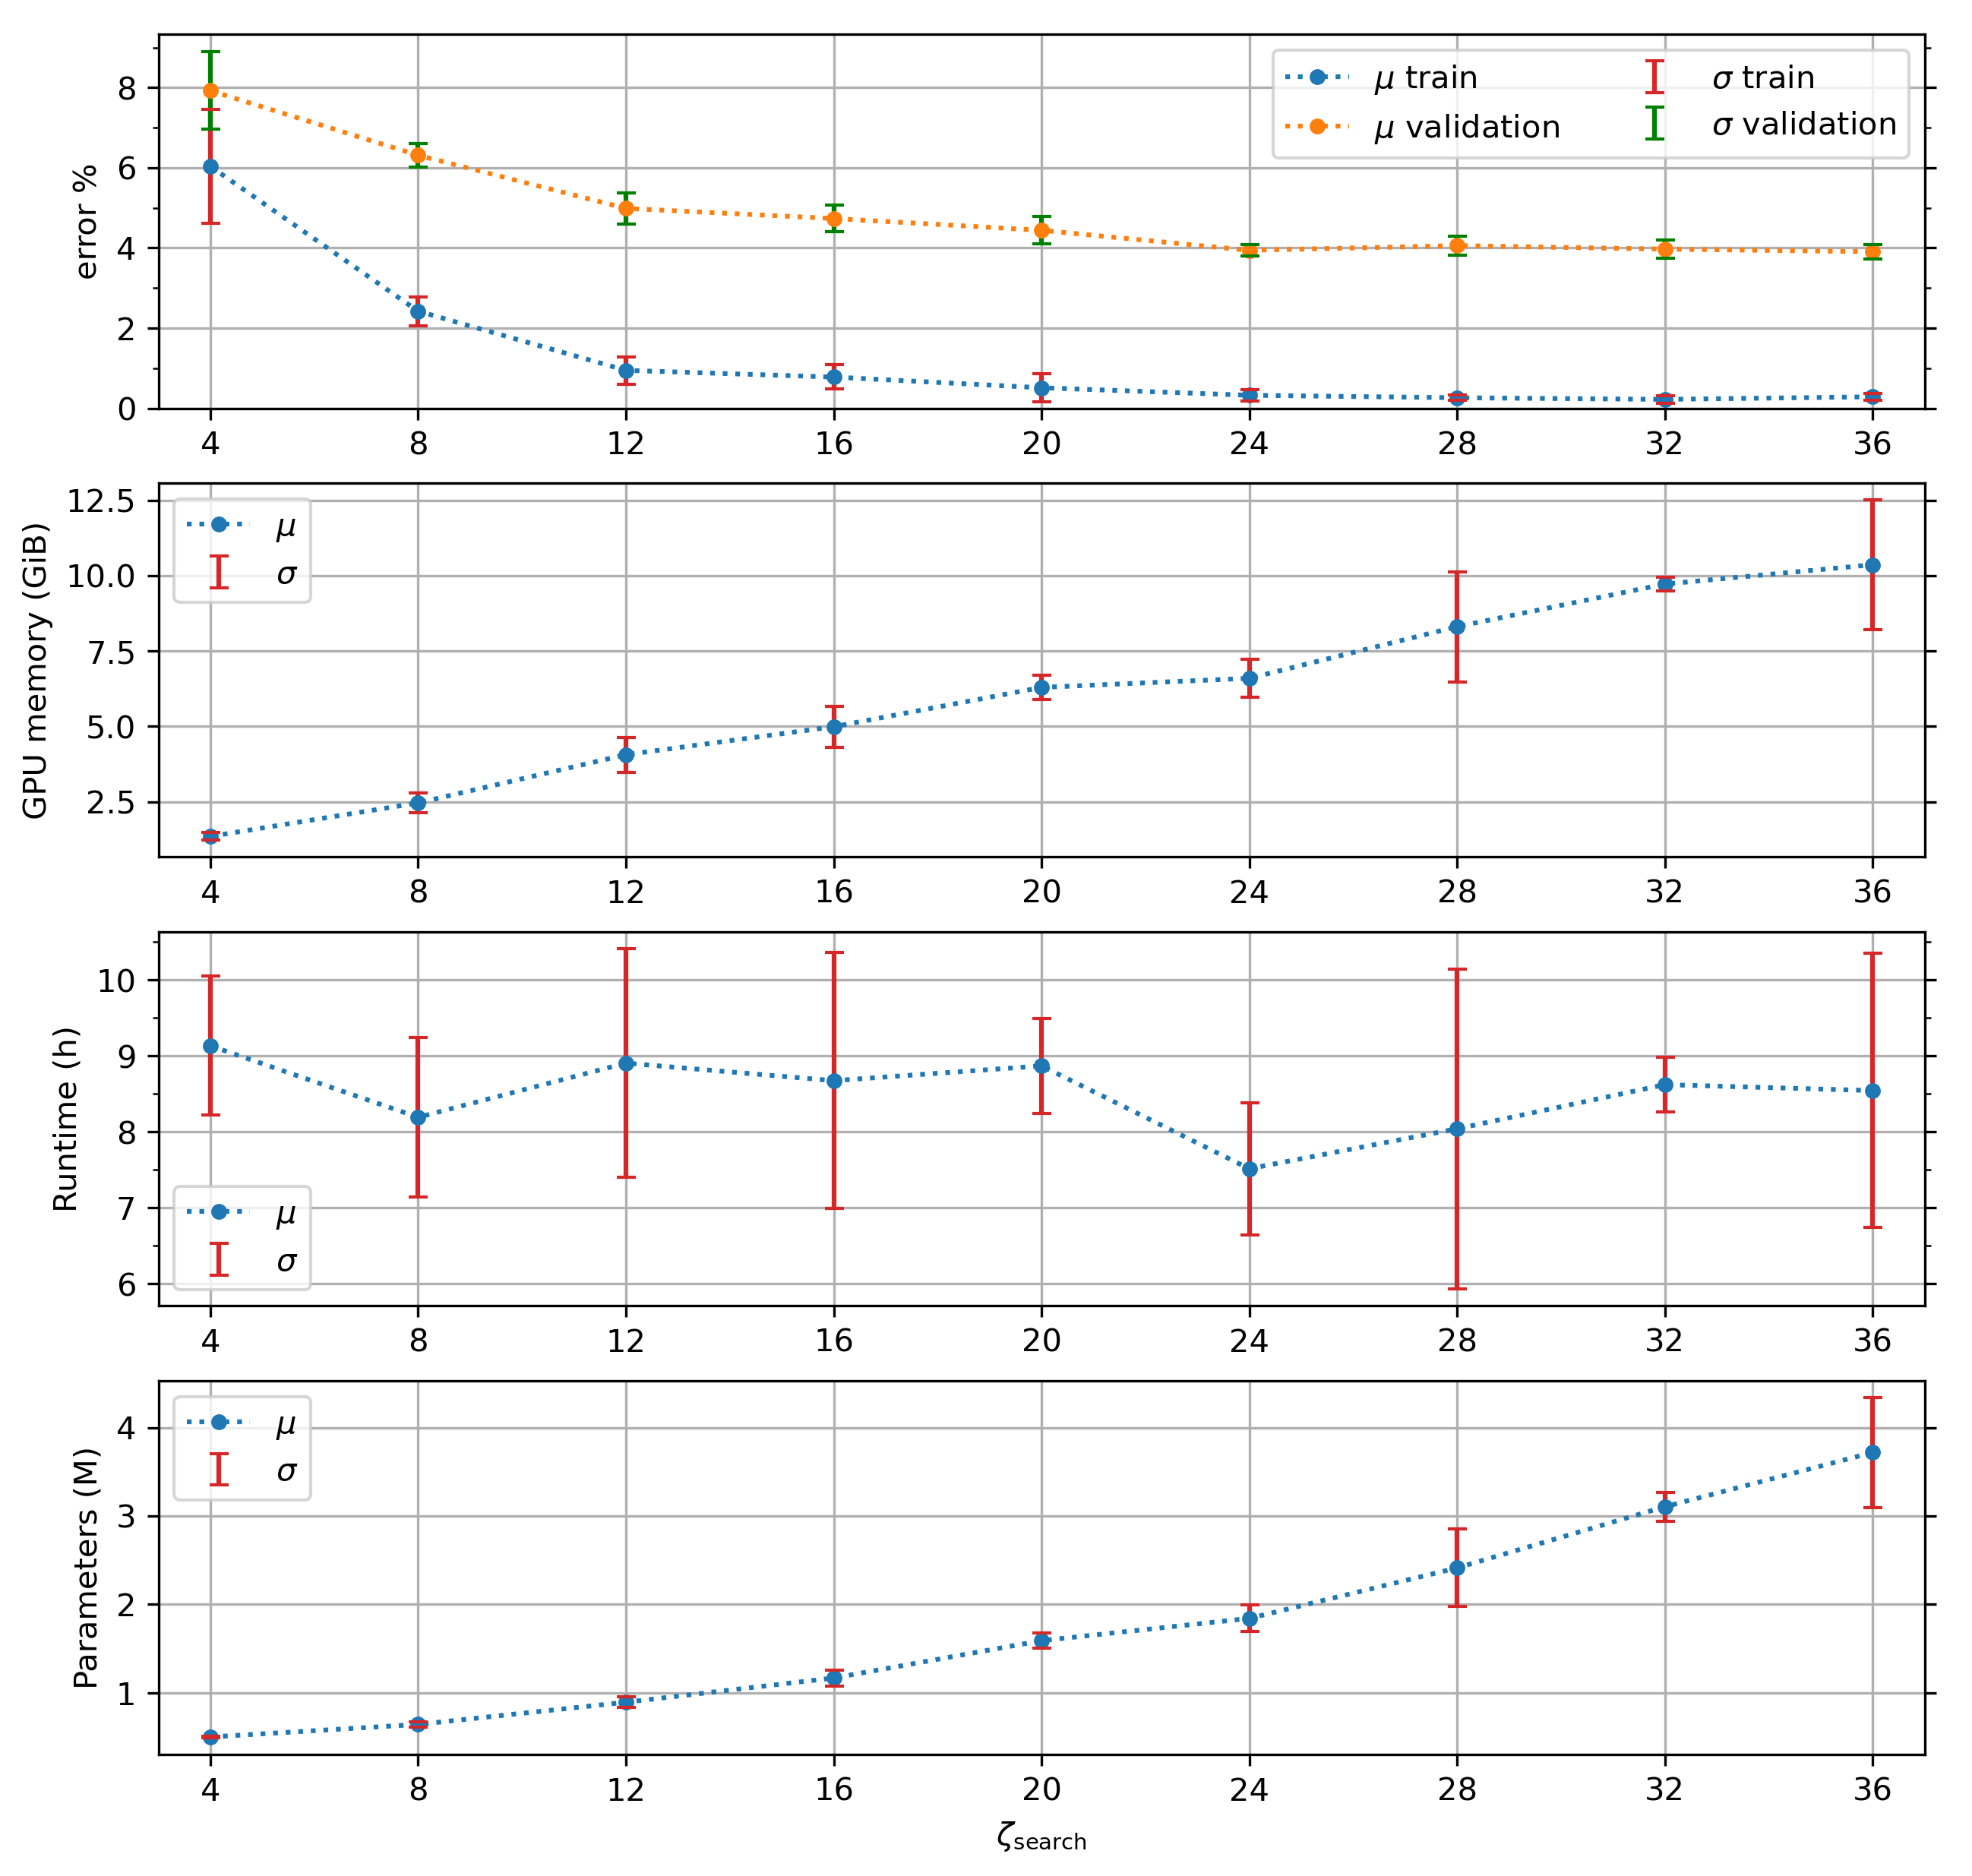

const


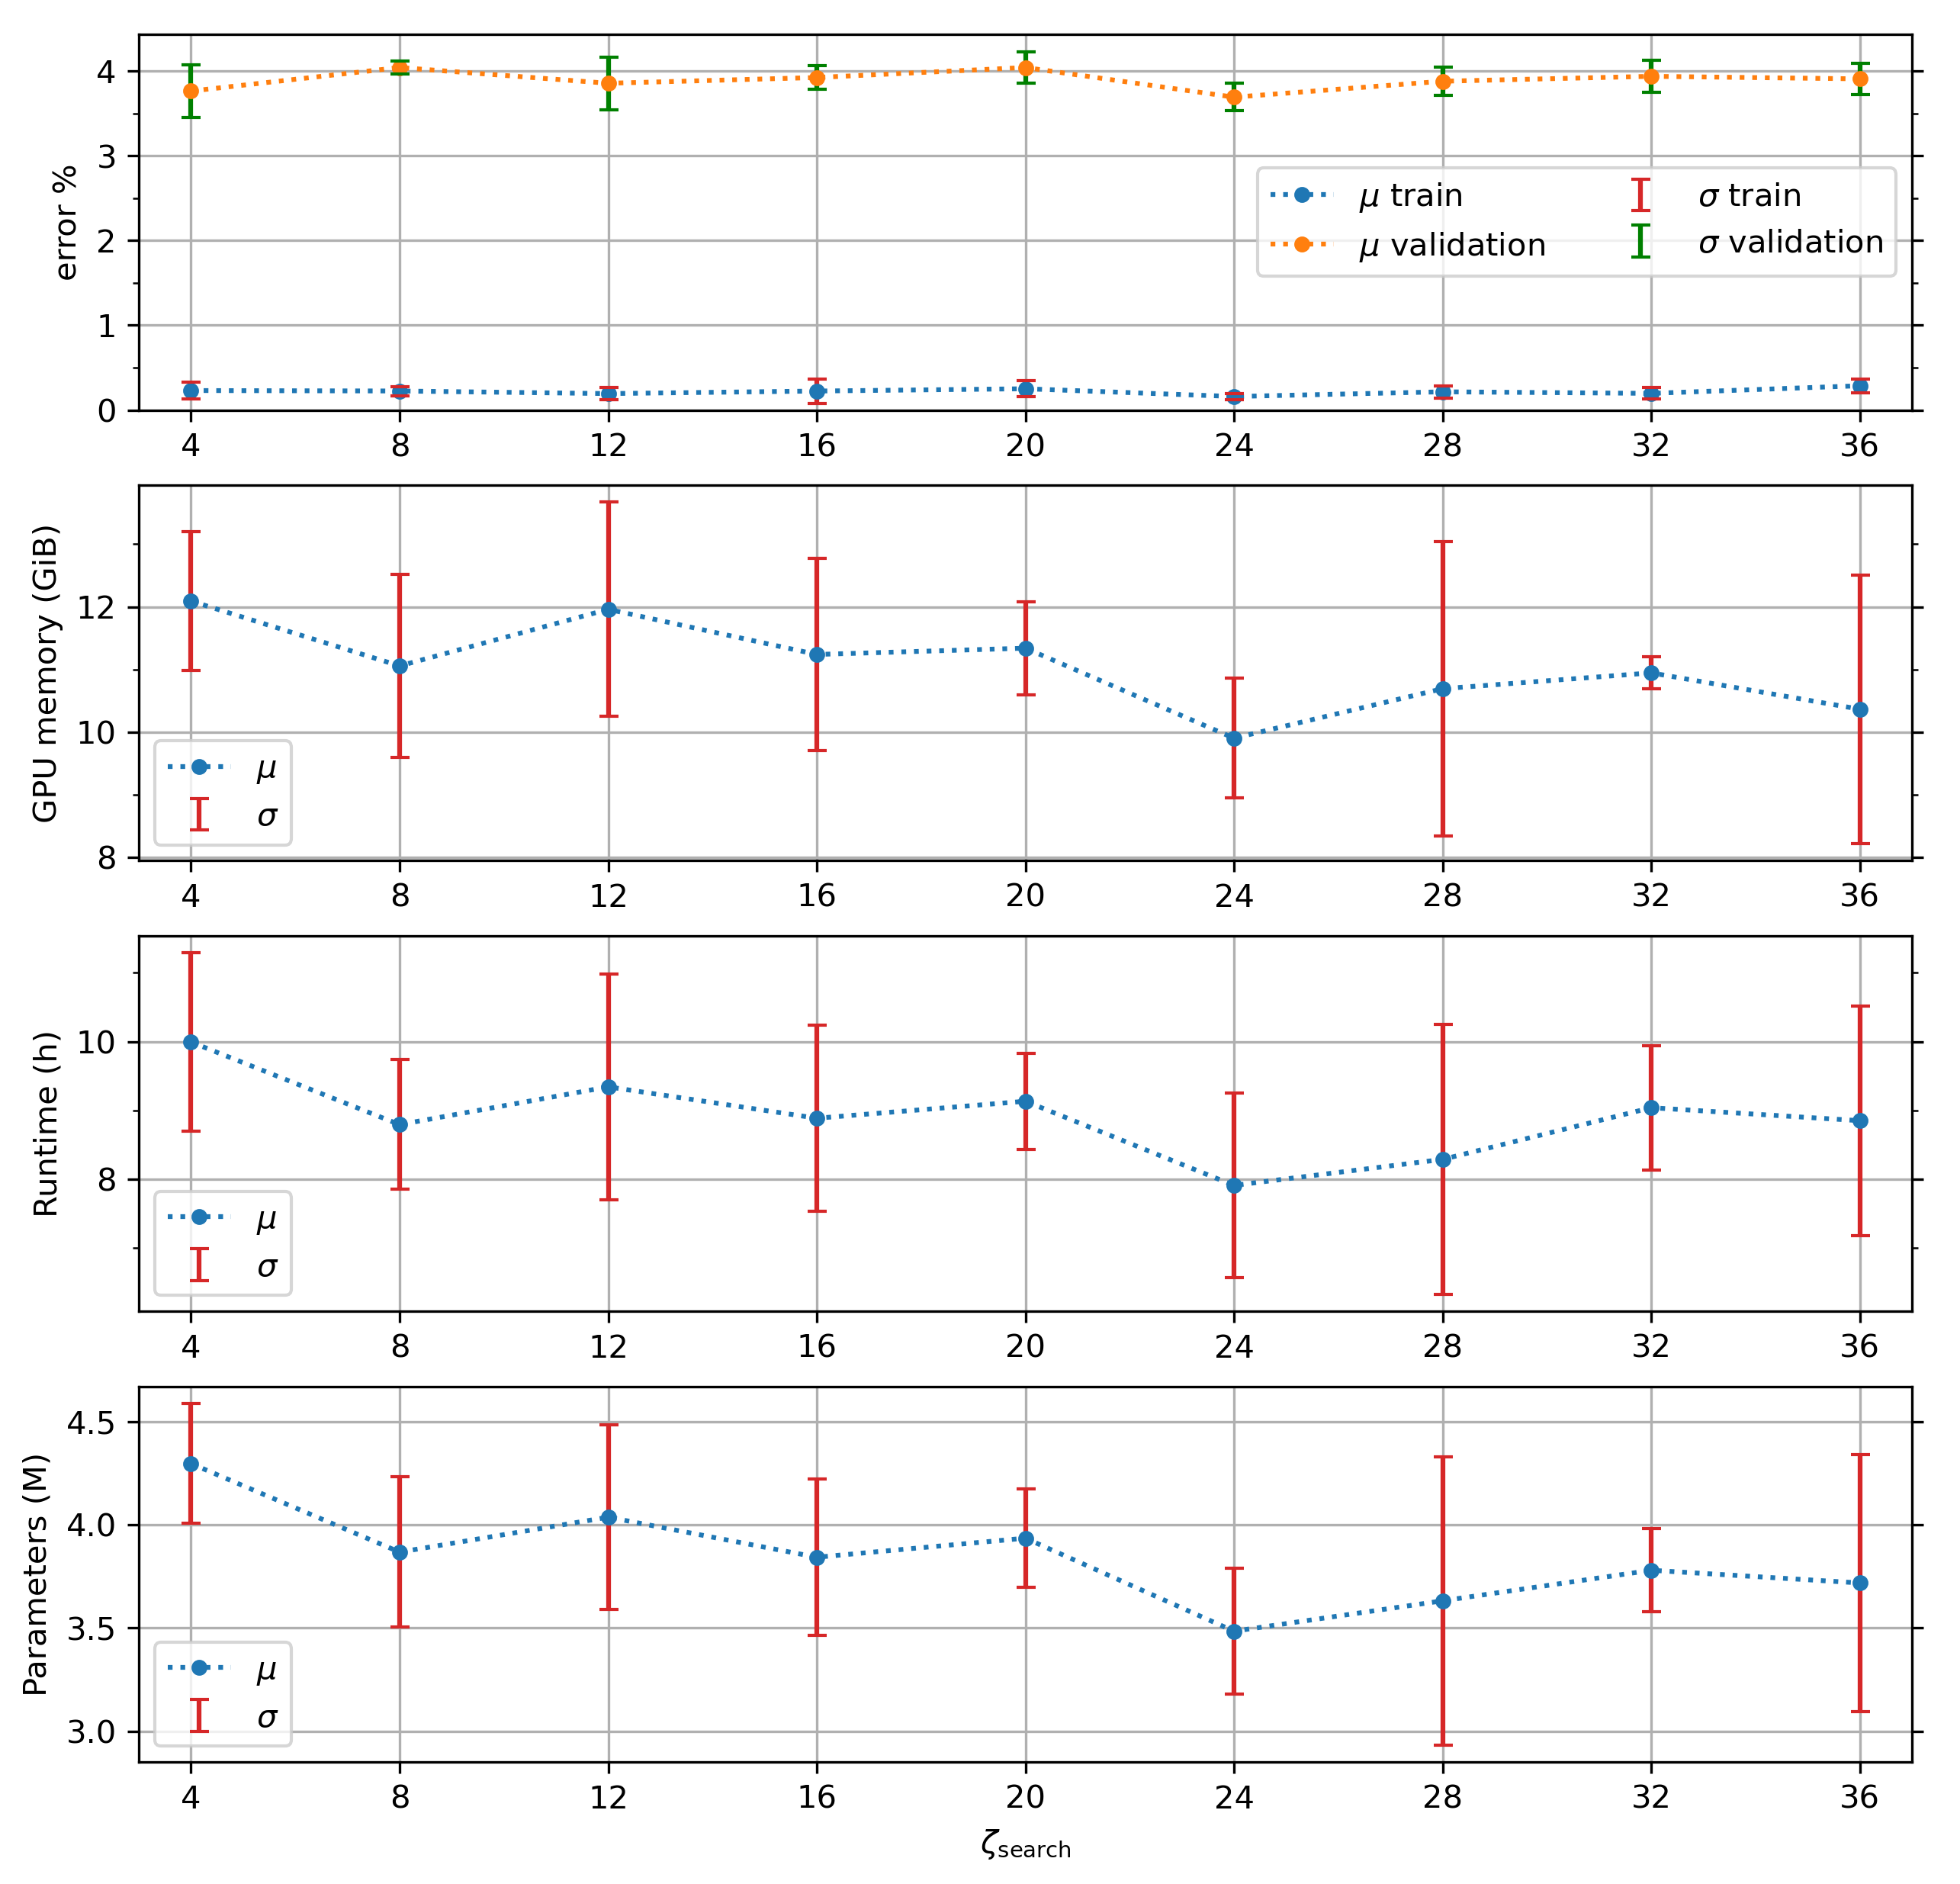

In [129]:
for Psi in ["same", "const"]:
    print(Psi)
    plt.rcParams['xtick.direction'] = 'out'
    plt.rcParams['ytick.direction'] = 'out'
    fig = plt.figure(figsize=(10, 10), dpi=300)
    #fig.suptitle(
    #    (
    #        "Train and validation error, GPU memory consumption, parameter count and runtime of\n"
    #        r"the evaluation phase for different $\zeta_\mathrm{search}$ over 5 random seeds"
    #        f"\non 6 NVIDIA {gpu.upper()} GPUs"
    #    ), y=0.96)
    overall = fig.add_subplot(111)
    overall.spines['top'].set_color('none')
    overall.spines['bottom'].set_color('none')
    overall.spines['left'].set_color('none')
    overall.spines['right'].set_color('none')
    overall.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
    overall.set_xlabel(r'$\zeta_\mathrm{search}$')

    error = fig.add_subplot(411)
    mem = fig.add_subplot(412)
    runtime = fig.add_subplot(413)
    parameter = fig.add_subplot(414)
    for ax in fig.get_axes()[1:]:
        #ax.yaxis.set_minor_locator(MultipleLocator(1))
        ax.grid()
        ax.set_xlim([init_channels_searched[0]-1, init_channels_searched[-1]+1])
        ax.set_xticks(init_channels_searched)
        ax.yaxis.set_ticks_position('both')
    if Psi == "same":
        error.yaxis.set_minor_locator(MultipleLocator(1))
        runtime.yaxis.set_minor_locator(MultipleLocator(0.5))
        parameter.yaxis.set_minor_locator(MultipleLocator(1))
    else:
        error.yaxis.set_minor_locator(MultipleLocator(0.5))
        runtime.yaxis.set_minor_locator(MultipleLocator(1))
        mem.yaxis.set_minor_locator(MultipleLocator(1))

    # plot train and validation error
    error.plot(
        init_channels_searched,
        100 - plot_arrays[Psi]['train']['mean'],
        linestyle="dotted",
        marker="o",
        markersize=4,
        color="C0",
        #zorder=-3
    )
    error.plot(
        init_channels_searched,
        100 - plot_arrays[Psi]['valid']['mean'],
        linestyle="dotted",
        marker="o",
        markersize=4,
        color="C1",
        #zorder=-3
    )
    error.errorbar(
        init_channels_searched, 
        100 - plot_arrays[Psi]['train']['mean'], 
        plot_arrays[Psi]['train']['std'],
        fmt="None",
        capsize=3,
        color="C3"
    )
    error.errorbar(
        init_channels_searched,
        100 - plot_arrays[Psi]['valid']['mean'],
        plot_arrays[Psi]['valid']['std'],
        fmt="None",
        capsize=3,
        color="g"
    )
    #error.scatter(
    #    init_channels_searched,
    #    100 - plot_arrays[Psi]['train']['mean'],
    #    s = 10,
    #    marker="o",
    #    color="C0"
    #)
    #error.scatter(
    #    init_channels_searched,
    #    100 - plot_arrays[Psi]['valid']['mean'],
    #    s=10,
    #    marker="o",
    #    color="C1"
    #)
    error.set_ylabel("error %")
    error.legend(
        [r'$\mu$ train', r'$\mu$ validation', r'$\sigma$ train', r'$\sigma$ validation'],
        ncol=2
    )

    # plot gpu memory consumption
    #mem.scatter(
    #    init_channels_searched,
    #    plot_arrays[Psi]['mem']['mean']/1024,
    #    s=10,
    #    marker="o",
    #    color="C0"
    #)
    mem.plot(
        init_channels_searched,
        plot_arrays[Psi]['mem']['mean']/1024,
        linestyle="dotted",
        marker="o",
        markersize=4,
        color="C0"
    )
    mem.errorbar(
        init_channels_searched,
        plot_arrays[Psi]['mem']['mean']/1024,
        plot_arrays[Psi]['mem']['std']/1024,
        fmt="None",
        capsize=3,
        color="C3"
    )
    mem.set_ylabel("GPU memory (GiB)")
    mem.legend([r'$\mu$', r'$\sigma$'])

    # plot runtimes
    #runtime.scatter(
    #    init_channels_searched,
    #    plot_arrays[Psi]['runtime_raw']['mean']/3600,
    #    s=10,
    #    marker='o',
    #    color="C0"
    #)
    runtime.plot(
        init_channels_searched,
        plot_arrays[Psi]['runtime_raw']['mean']/3600,
        linestyle="dotted",
        marker="o",
        markersize=4,
        color="C0"
    )
    runtime.errorbar(
        init_channels_searched,
        plot_arrays[Psi]['runtime_raw']['mean']/3600,
        plot_arrays[Psi]['runtime_raw']['std']/3600,
        fmt='None',
        capsize=3,
        color="C3"
    )
    runtime.set_ylabel("Runtime (h)")
    runtime.legend([r'$\mu$', r'$\sigma$'])
    
    # plot parameters
    #parameter.scatter(
    #    init_channels_searched,
    #    plot_arrays[Psi]['parameters']['mean']/1e6,
    #    s=10,
    #    marker="o",
    #    color="C0"
    #)
    parameter.plot(
        init_channels_searched,
        plot_arrays[Psi]['parameters']['mean']/1e6,
        linestyle="dotted",
        marker="o",
        markersize=4,
        color="C0"
    )
    parameter.errorbar(
        init_channels_searched,
        plot_arrays[Psi]['parameters']['mean']/1e6,
        plot_arrays[Psi]['parameters']['std']/1e6,
        fmt="None",
        capsize=3,
        color="C3"
    )
    parameter.set_ylabel("Parameters (M)")
    parameter.legend([r'$\mu$', r'$\sigma$'])
    error.set_ylim(bottom=0)
    
    plt.savefig(f"images/exp_1_eval_{Psi}.svg", bbox_inches="tight")

    plt.show()

# Plots for complete training of a single search phase

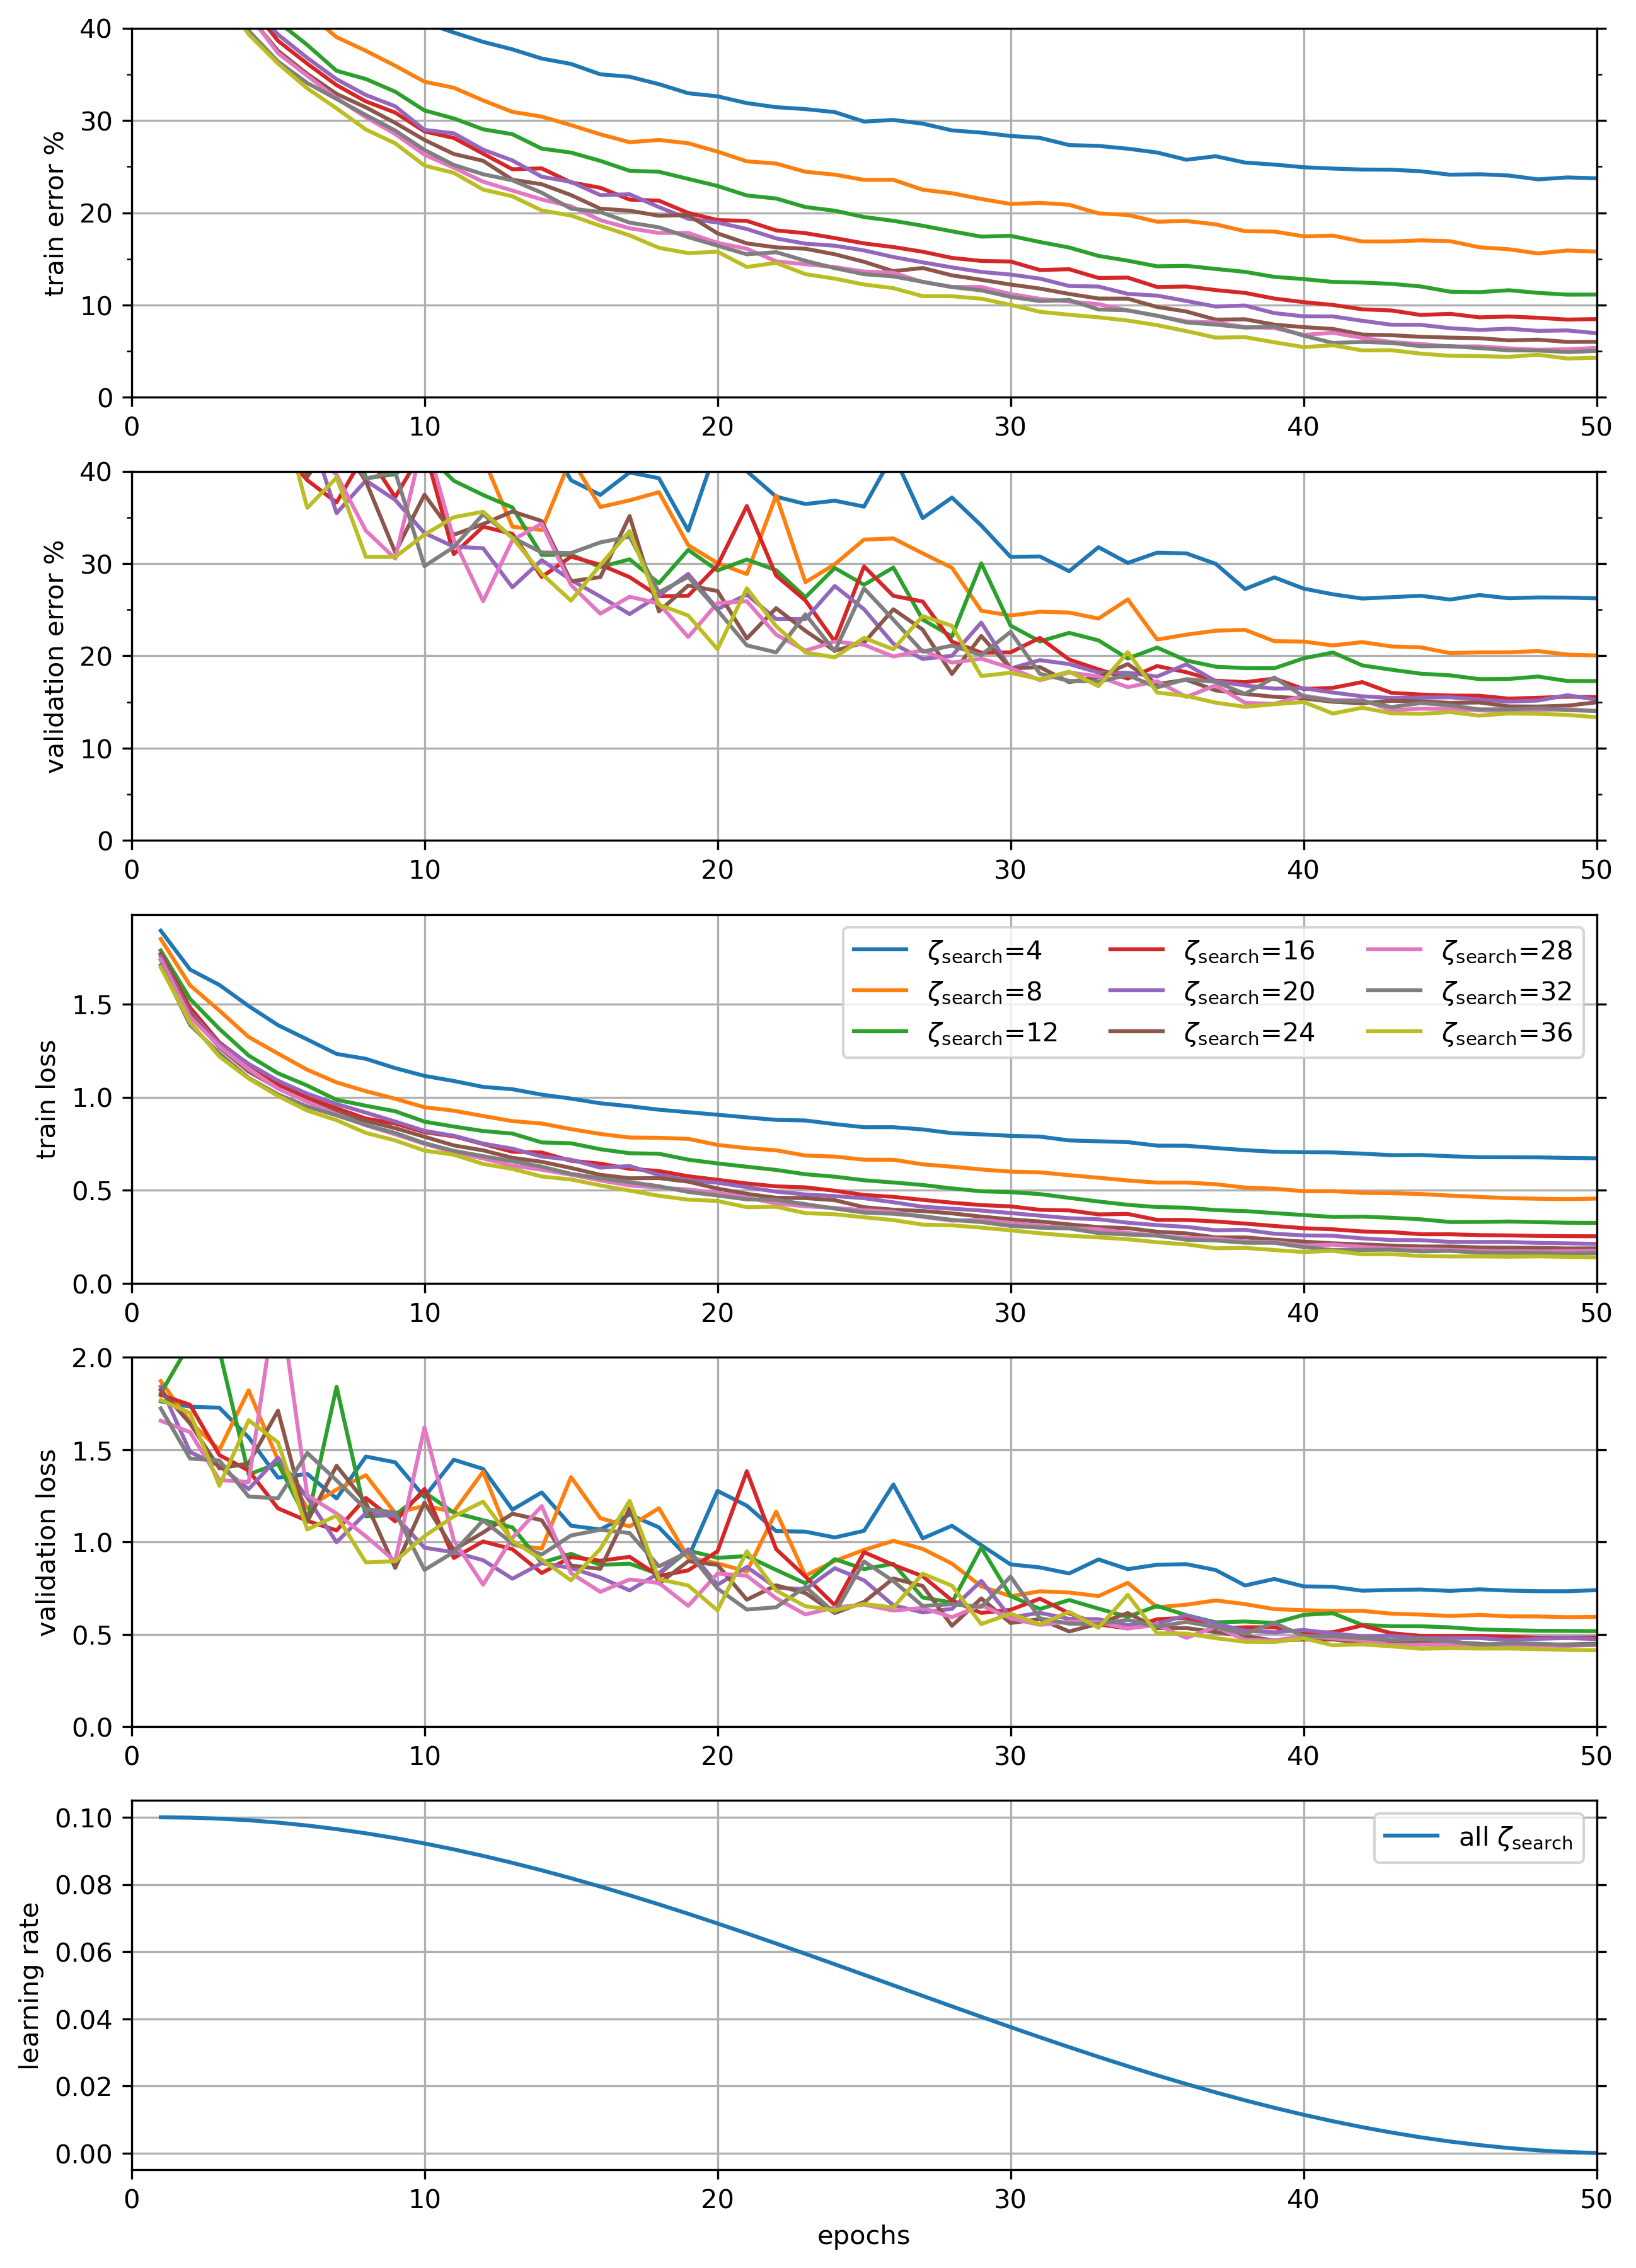

In [45]:
seed = 2554
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
fig = plt.figure(figsize=(10, 15), dpi=300)
overall = fig.add_subplot(111)
overall.spines['top'].set_color('none')
overall.spines['bottom'].set_color('none')
overall.spines['left'].set_color('none')
overall.spines['right'].set_color('none')
overall.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
overall.set_xlabel('epochs')

train_error = fig.add_subplot(511)
valid_error = fig.add_subplot(512)
train_loss = fig.add_subplot(513)
valid_loss = fig.add_subplot(514)
lr = fig.add_subplot(515)

epochs = len(train_details["search"][seed][4]['Top1/train'])

for ax in fig.get_axes()[1:]:
    ax.grid()
    ax.set_xlim([0, epochs])
    ax.yaxis.set_ticks_position('both')
    
    
train_error.yaxis.set_minor_locator(MultipleLocator(5))
valid_error.yaxis.set_minor_locator(MultipleLocator(5))
    
# plot curves for all zeta
for index, zeta in enumerate(init_channels_searched):
    train_error.plot(
        np.arange(1, epochs+1),
        100 - train_details["search"][seed][zeta]["Top1/train"],
        color=f"C{index}"
    )
    
    valid_error.plot(
        np.arange(1, epochs+1),
        100 - train_details["search"][seed][zeta]["Top1/valid"],
        color=f"C{index}"
    )
    
    train_loss.plot(
        np.arange(1, epochs+1),
        train_details["search"][seed][zeta]["Loss/train"],
        color=f"C{index}"
    )
    
    valid_loss.plot(
        np.arange(1, epochs+1),
        train_details["search"][seed][zeta]["Loss/valid"],
        color=f"C{index}"
    )

# plot learning rate curve
lr.plot(
    np.arange(1, epochs+1),
    train_details["search"][seed][4]["lr"],
)
    
#train_error.legend(
#    [
#        (
#            r"$\zeta_\mathrm{search}$="
#            f"{x}"
#        )
#        for x in init_channels_searched
#    ],
#    loc="upper right",
#    ncol=3
#)
train_error.set_ylabel('train error %')

#valid_error.legend(
#    [
#        (
#            r"$\zeta_\mathrm{search}$="
#            f"{x}"
#        )
#        for x in init_channels_searched
#    ],
#    loc="upper right",
#    ncol=3
#)
valid_error.set_ylabel('validation error %')

train_loss.legend(
    [
        (
            r"$\zeta_\mathrm{search}$="
            f"{x}"
        )
        for x in init_channels_searched
    ],
    loc="upper right",
    ncol=3
)
train_loss.set_ylabel('train loss')

#valid_loss.legend(
#    [
#        (
#            r"$\zeta_\mathrm{search}$="
#            f"{x}"
#        )
#        for x in init_channels_searched
#    ],
#    loc="upper right",
#    ncol=3
#)
valid_loss.set_ylabel('validation loss')

lr.legend([r'all $\zeta_\mathrm{search}$'])
lr.set_ylabel("learning rate")

train_error.set_ylim(bottom=0, top=40)
valid_error.set_ylim(bottom=0, top=40)
train_loss.set_ylim(bottom=0)
valid_loss.set_ylim(bottom=0, top=2)

plt.savefig(f"images/exp_1_search_training_seed_{seed}.svg", bbox_inches='tight')

plt.show()

# Plots for complete training of $\Psi_\mathrm{same}$ and $\Psi_\mathrm{const}$ evaluation phases

const


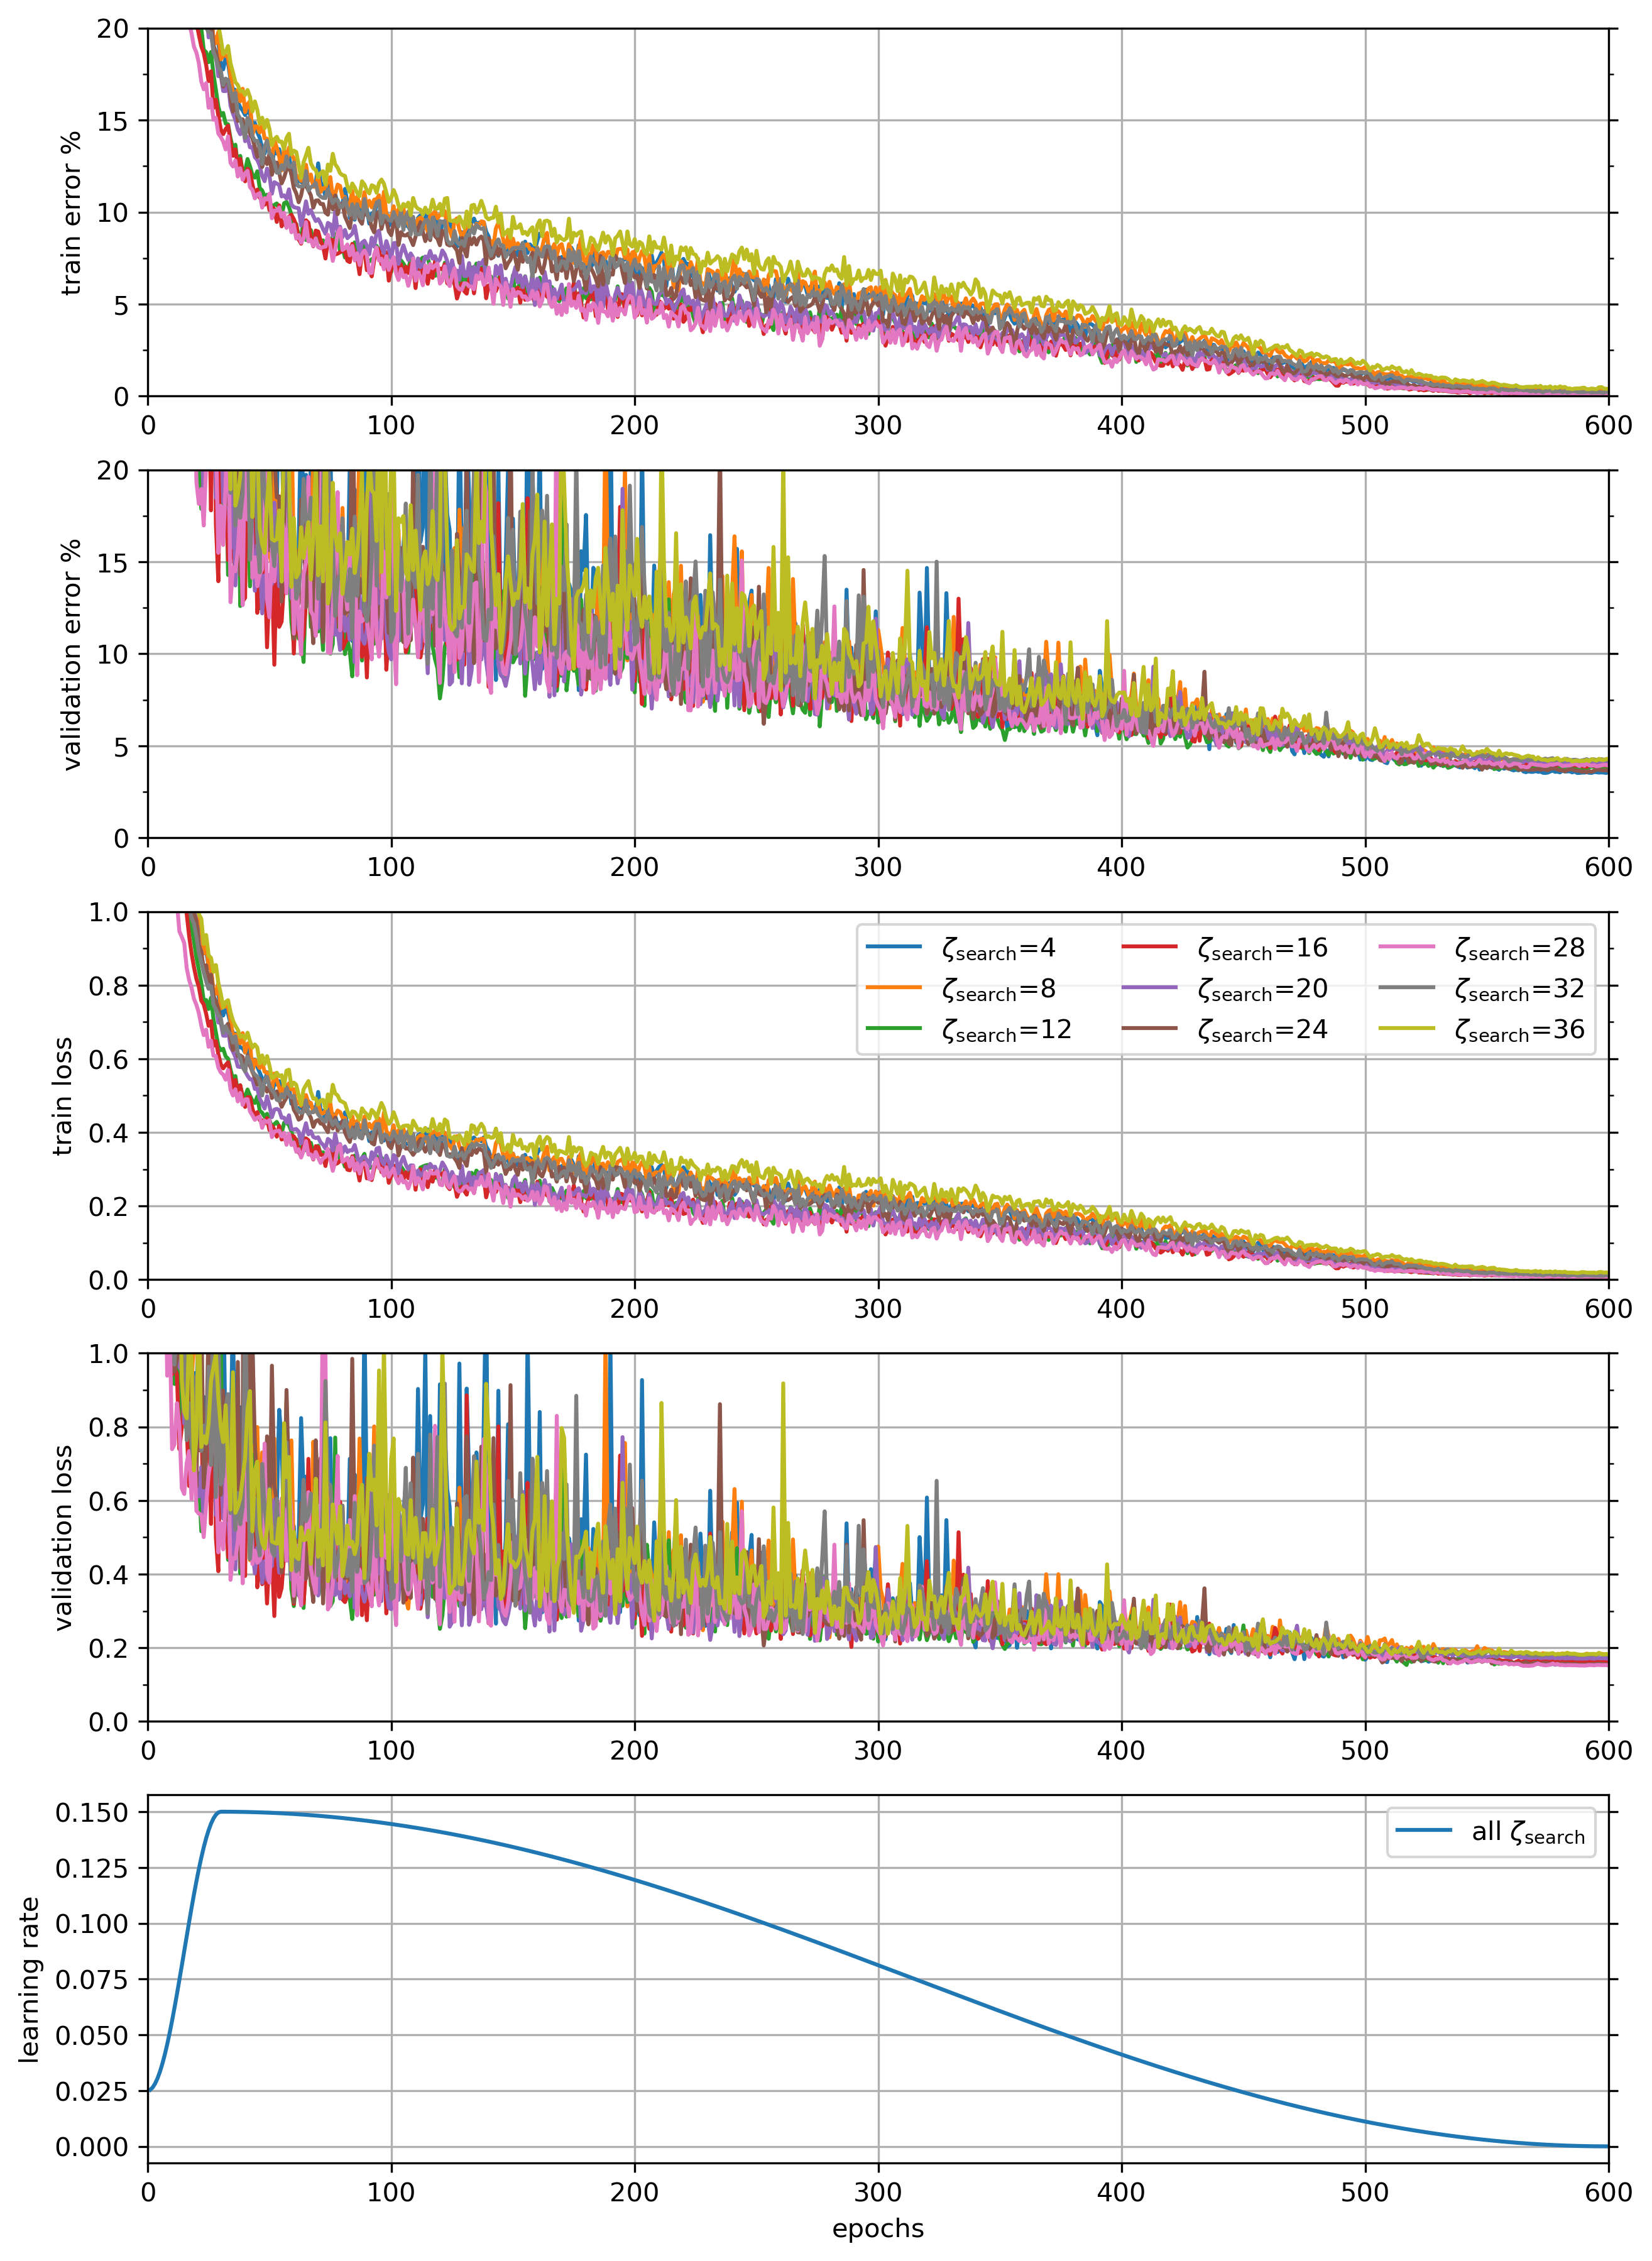

In [16]:
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
seed = 2554
for Psi in ["const"]:#["same", "const"]:
    print(Psi)
    fig = plt.figure(figsize=(10, 15), dpi=300)
    overall = fig.add_subplot(111)
    overall.spines['top'].set_color('none')
    overall.spines['bottom'].set_color('none')
    overall.spines['left'].set_color('none')
    overall.spines['right'].set_color('none')
    overall.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
    overall.set_xlabel('epochs')

    train_error = fig.add_subplot(511)
    valid_error = fig.add_subplot(512)
    train_loss = fig.add_subplot(513)
    valid_loss = fig.add_subplot(514)
    lr = fig.add_subplot(515)

    epochs = len(train_details[Psi][seed][4]['Top1/train'])

    for ax in fig.get_axes()[1:]:
        ax.grid()
        ax.set_xlim([0, epochs])
        ax.yaxis.set_ticks_position('both')
        
    train_error.yaxis.set_minor_locator(MultipleLocator(2.5))
    valid_error.yaxis.set_minor_locator(MultipleLocator(2.5))
    train_loss.yaxis.set_minor_locator(MultipleLocator(0.1))
    valid_loss.yaxis.set_minor_locator(MultipleLocator(0.1))

    # plot curves for all zeta
    for index, zeta in enumerate(init_channels_searched):
        train_error.plot(
            np.arange(1, epochs+1),
            100 - train_details[Psi][seed][zeta]["Top1/train"],
            color=f"C{index}"
        )

        valid_error.plot(
            np.arange(1, epochs+1),
            100 - train_details[Psi][seed][zeta]["Top1/valid"],
            color=f"C{index}"
        )

        train_loss.plot(
            np.arange(1, epochs+1),
            train_details[Psi][seed][zeta]["Loss/train"],
            color=f"C{index}"
        )

        valid_loss.plot(
            np.arange(1, epochs+1),
            train_details[Psi][seed][zeta]["Loss/valid"],
            color=f"C{index}"
        )

    # plot learning rate curve
    lr.plot(
        np.arange(1, epochs+1),
        train_details[Psi][seed][4]["lr"],
        #color="k"
    )

    train_loss.legend(
        [
            (
                r"$\zeta_\mathrm{search}$="
                f"{x}"
            )
            for x in init_channels_searched
        ],
        loc="upper right",
        ncol=3,
        fontsize="medium"
    )
    train_error.set_ylabel('train error %')

    #valid_error.legend(
    #    [
    #        (
    #            r"$\zeta_\mathrm{search}$="
    #            f"{x}"
    #        )
    #        for x in init_channels_searched
    #    ],
    #    loc="lower left" if Psi == "same" else "upper right",
    #    ncol=3
    #)
    valid_error.set_ylabel('validation error %')

    #train_loss.legend(
    #    [
    #        (
    #            r"$\zeta_\mathrm{search}$="
    #            f"{x}"
    #        )
    #        for x in init_channels_searched
    #    ],
    #    loc="upper right",
    #    ncol=3
    #)
    train_loss.set_ylabel('train loss')

    #valid_loss.legend(
    #    [
    #        (
    #            r"$\zeta_\mathrm{search}$="
    #            f"{x}"
    #        )
    #        for x in init_channels_searched
    #    ],
    #    loc="upper right",
    #    ncol=3
    #)
    valid_loss.set_ylabel('validation loss')

    lr.legend([r'all $\zeta_\mathrm{search}$'])
    lr.set_ylabel("learning rate")
    
    train_error.set_ylim(bottom=0, top=20)
    valid_error.set_ylim(bottom=0, top=20)
    train_loss.set_ylim(bottom=0, top=1)
    valid_loss.set_ylim(bottom=0, top=1)

    plt.savefig(f"images/exp_1_eval_{Psi}_training_seed_{seed}.svg", bbox_inches='tight')

    plt.show()

In [69]:
ckpts_eval[4]['history']

{24: {'checkpoint_path': '/beegfs/global0/ws/s8732099-diploma_thesis/experiments_da/exp_1_eval_4/v100/grid_search-batch_size_256/evaluation_phase_seed_2554/checkpoints/checkpoint_init_channels_24/model_best.ckpt',
  'best_weights_train_time': 22799.30321592372,
  'train_acc': 90.67546844482422,
  'valid_acc': 90.93181610107422,
  'overall_eval_time': 23940.811050157994,
  'max_mem_allocated_MB': 1075.622912,
  'max_mem_reserved_MB': 1094.713344,
  'model_parameters': 466456}}

In [74]:
print(100 - np.asarray(
        [ckpts_eval[eval_channel]['history'][24]['train_acc'] for eval_channel in evaluation_channels_searched]
    )
)
print(evaluation_channels_searched)


[9.32453156 1.16244507 0.48246765 0.19748688 0.1674881  0.2224884
 0.11248779 0.06748962 0.05999756 0.05499268]
[4, 12, 24, 36, 48, 60, 72, 84, 96, 108]


# Plot for different $\zeta_\mathrm{eval}$ for a fixed $\zeta_\mathrm{search} = 24$

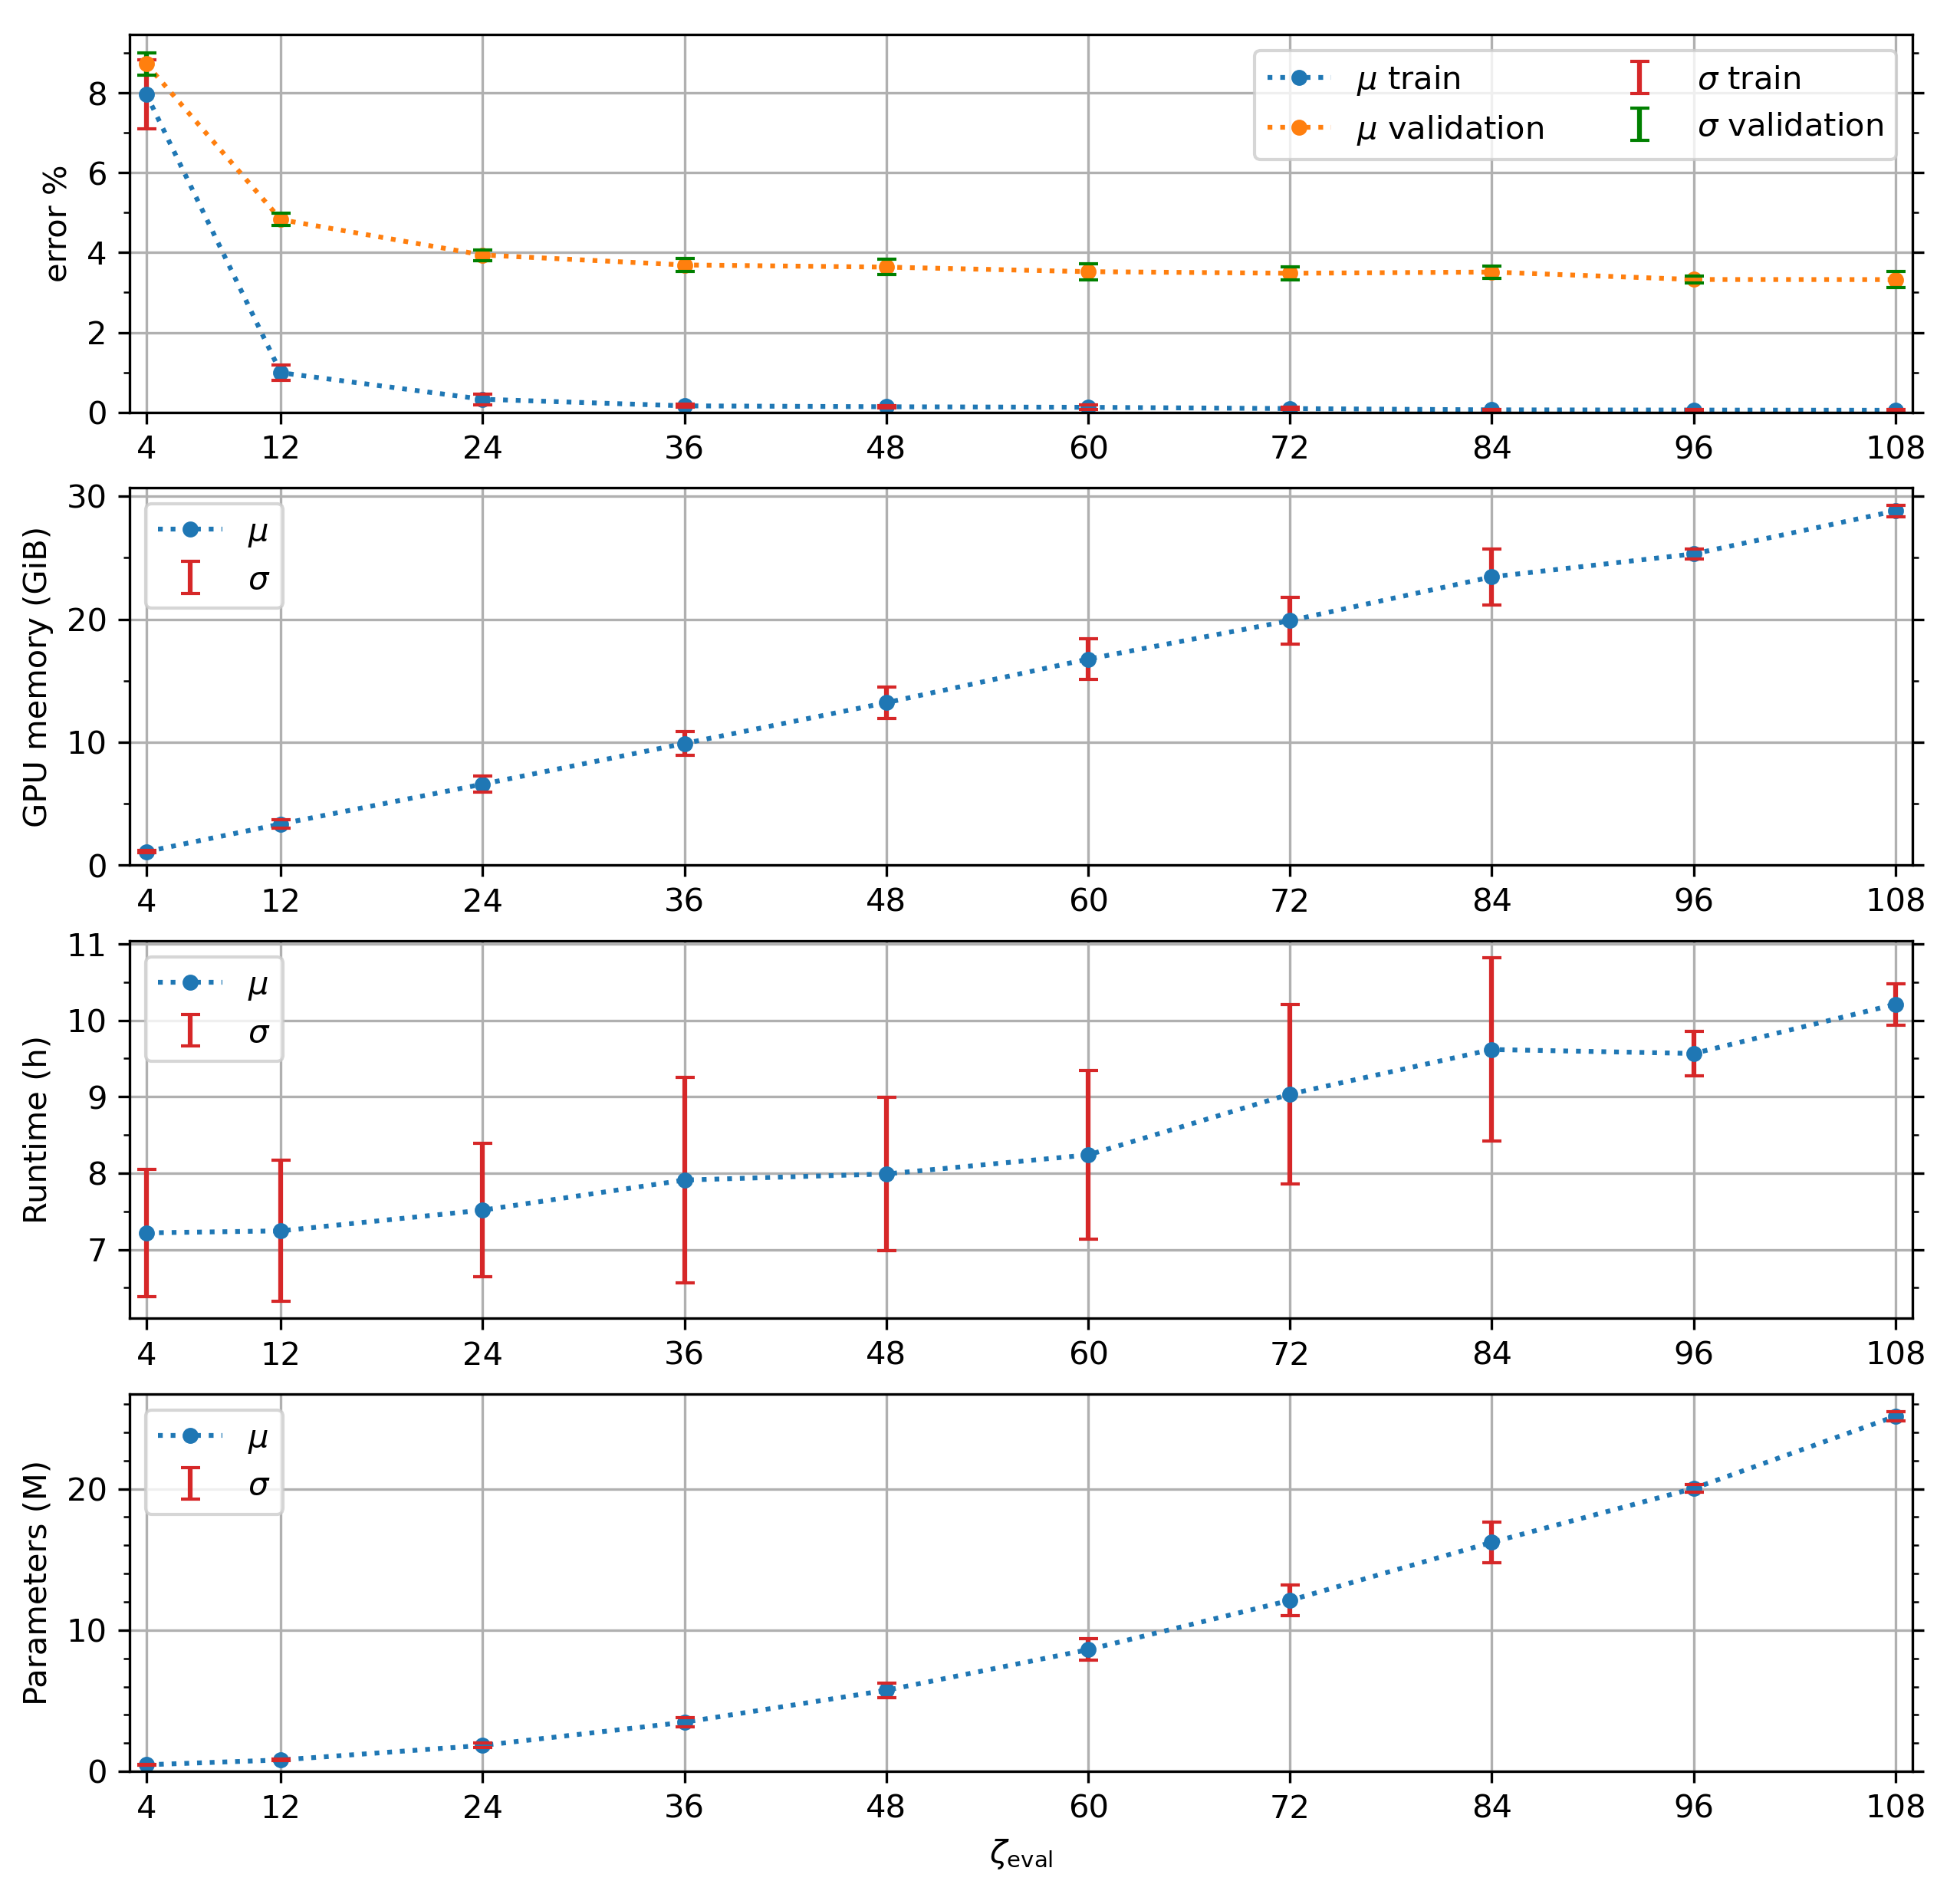

In [137]:
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
fig = plt.figure(figsize=(10, 10), dpi=300)
#fig.suptitle(
#    (
#        "Train and validation error, GPU memory consumption, parameter count and runtime of\n"
#        r"the evaluation phase for different $\zeta_\mathrm{search}$ over 5 random seeds"
#        f"\non 6 NVIDIA {gpu.upper()} GPUs"
#    ), y=0.96)
overall = fig.add_subplot(111)
overall.spines['top'].set_color('none')
overall.spines['bottom'].set_color('none')
overall.spines['left'].set_color('none')
overall.spines['right'].set_color('none')
overall.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
overall.set_xlabel(r'$\zeta_\mathrm{eval}$')

error = fig.add_subplot(411)
mem = fig.add_subplot(412)
runtime = fig.add_subplot(413)
parameter = fig.add_subplot(414)
for ax in fig.get_axes()[1:]:
    #ax.yaxis.set_minor_locator(MultipleLocator(1))
    ax.grid()
    ax.set_xlim([evaluation_channels_searched[0]-1, evaluation_channels_searched[-1]+1])
    ax.set_xticks(evaluation_channels_searched)
    ax.yaxis.set_ticks_position('both')

error.yaxis.set_minor_locator(MultipleLocator(1))
runtime.yaxis.set_minor_locator(MultipleLocator(0.5))
mem.yaxis.set_minor_locator(MultipleLocator(5))
parameter.yaxis.set_minor_locator(MultipleLocator(2))

# plot train and validation error
#error.scatter(
#    evaluation_channels_searched,
#    100 - np.asarray(
#        [eval_phases_averaged[eval_channel]['train']['mean'] for eval_channel in evaluation_channels_searched]
#    ),
#    marker="x",
#    s=40,
#    color="C0"
#)
error.plot(
    evaluation_channels_searched,
    100 - np.asarray(
        [eval_phases_averaged[eval_channel]['train']['mean'] for eval_channel in evaluation_channels_searched]
    ),
    linestyle='dotted',
    marker="o",
    markersize=4,
    label="train",
    color="C0"
)
error.errorbar(
    evaluation_channels_searched,
    100 - np.asarray(
        [eval_phases_averaged[eval_channel]['train']['mean'] for eval_channel in evaluation_channels_searched]
    ),
    [eval_phases_averaged[eval_channel]['train']['std'] for eval_channel in evaluation_channels_searched],
    fmt="None",
    capsize=3,
    color="C3"
)

#error.scatter(
#    evaluation_channels_searched,
#    100 - np.asarray(
#        [eval_phases_averaged[eval_channel]['valid']['mean'] for eval_channel in evaluation_channels_searched]
#    ),
#    marker="x",
#    s=40,
#    color="C1"
#)
error.plot(
    evaluation_channels_searched,
    100 - np.asarray(
        [eval_phases_averaged[eval_channel]['valid']['mean'] for eval_channel in evaluation_channels_searched]
    ),
    linestyle="dotted",
    marker="o",
    markersize=4,
    label="valid",
    color="C1"
)
error.errorbar(
    evaluation_channels_searched,
    100 - np.asarray(
        [eval_phases_averaged[eval_channel]['valid']['mean'] for eval_channel in evaluation_channels_searched]
    ),
    [eval_phases_averaged[eval_channel]['valid']['std'] for eval_channel in evaluation_channels_searched],
    fmt="None",
    capsize=3,
    color="g"
)

error.set_ylabel("error %")
error.legend(
    [r'$\mu$ train', r'$\mu$ validation', r'$\sigma$ train', r'$\sigma$ validation'],
    ncol=2
)

# plot gpu memory consumption
#mem.scatter(
#    evaluation_channels_searched,
#    np.asarray(
#        [eval_phases_averaged[eval_channel]['mem']['mean'] for eval_channel in evaluation_channels_searched]
#    ) / 1024,
#    s=40,
#    marker="x",
#    color="C0"
#)
mem.plot(
    evaluation_channels_searched,
    np.asarray(
        [eval_phases_averaged[eval_channel]['mem']['mean'] for eval_channel in evaluation_channels_searched]
    ) / 1024,
    linestyle="dotted",
    marker="o",
    markersize=4,
    color="C0"
)
mem.errorbar(
    evaluation_channels_searched,
    np.asarray(
        [eval_phases_averaged[eval_channel]['mem']['mean'] for eval_channel in evaluation_channels_searched]
    ) / 1024,
    np.asarray(
        [eval_phases_averaged[eval_channel]['mem']['std'] for eval_channel in evaluation_channels_searched]
    ) / 1024,
    fmt="None",
    capsize=3,
    color="C3"
)
mem.set_ylabel("GPU memory (GiB)")
mem.legend([r'$\mu$', r'$\sigma$'])

# plot runtimes
#runtime.scatter(
#    evaluation_channels_searched,
#    np.asarray(
#        [eval_phases_averaged[eval_channel]['runtime']['mean'] for eval_channel in evaluation_channels_searched]
#    ) / 3600,
#    s=40,
#    marker='x',
#    color="C0"
#)
runtime.plot(
    evaluation_channels_searched,
    np.asarray(
        [eval_phases_averaged[eval_channel]['runtime']['mean'] for eval_channel in evaluation_channels_searched]
    ) / 3600,
    linestyle="dotted",
    marker="o",
    markersize=4,
    color="C0"
)
runtime.errorbar(
    evaluation_channels_searched,
    np.asarray(
        [eval_phases_averaged[eval_channel]['runtime']['mean'] for eval_channel in evaluation_channels_searched]
    ) / 3600,
    np.asarray(
        [eval_phases_averaged[eval_channel]['runtime']['std'] for eval_channel in evaluation_channels_searched]
    ) / 3600,
    fmt="None",
    capsize=3,
    color="C3"
)
runtime.set_ylabel("Runtime (h)")
runtime.legend([r'$\mu$', r'$\sigma$'])

# plot parameters
#parameter.scatter(
#    evaluation_channels_searched,
#    np.asarray(
#        [ckpts_eval[eval_channel]['history'][24]['model_parameters'] for eval_channel in evaluation_channels_searched]
#    ) / 1e6,
#    s=40,
#    marker="x",
#    color="C0"
#)
parameter.plot(
    evaluation_channels_searched,
    np.asarray(
        [eval_phases_averaged[eval_channel]['params']['mean'] for eval_channel in evaluation_channels_searched]
    ) / 1e6,
    linestyle="dotted",
    marker="o",
    markersize=4,
    color="C0"
)
parameter.errorbar(
    evaluation_channels_searched,
    np.asarray(
        [eval_phases_averaged[eval_channel]['params']['mean'] for eval_channel in evaluation_channels_searched]
    ) / 1e6,
    np.asarray(
        [eval_phases_averaged[eval_channel]['params']['std'] for eval_channel in evaluation_channels_searched]
    ) / 1e6,
    fmt="None",
    capsize=3,
    color="C3"
)
parameter.set_ylabel("Parameters (M)")
parameter.legend([r'$\mu$', r'$\sigma$'])
error.set_ylim(bottom=0)
mem.set_ylim(bottom=0)
parameter.set_ylim(bottom=0)

#error.annotate(
#    "!", 
#    (106, 2),
#    color="r",
#    fontsize="xx-large"
#)


plt.savefig(f"images/exp_1_eval_search.svg", bbox_inches="tight")

plt.show()

# Visualize normal and reduction cells over all $\zeta$ for a given random seed

In [24]:
for zeta in init_channels_searched:
    plot_cells(
        genotype=checkpoints_search[2554]['history'][zeta]['best_genotype'].normal, 
        filename=f"images/exp_1_normal_cell_seed_2554_zeta_{zeta}", 
        output_format="pdf",
        return_type="render",
        view_render="False"
    )
    plot_cells(
        genotype=checkpoints_search[2554]['history'][zeta]['best_genotype'].reduce,
        filename=f"images/exp_1_reduction_cell_seed_2554_zeta_{zeta}", 
        output_format="pdf",
        return_type="render",
        view_render="False"
    )


(dot.exe:7588): Pango-WARNING **: couldn't load font "times Not-Rotated 20", falling back to "Sans Not-Rotated 20", expect ugly output.

(dot.exe:4860): Pango-WARNING **: couldn't load font "times Not-Rotated 20", falling back to "Sans Not-Rotated 20", expect ugly output.

(dot.exe:2236): Pango-WARNING **: couldn't load font "times Not-Rotated 20", falling back to "Sans Not-Rotated 20", expect ugly output.

(dot.exe:2088): Pango-WARNING **: couldn't load font "times Not-Rotated 20", falling back to "Sans Not-Rotated 20", expect ugly output.

(dot.exe:9188): Pango-WARNING **: couldn't load font "times Not-Rotated 20", falling back to "Sans Not-Rotated 20", expect ugly output.

(dot.exe:3776): Pango-WARNING **: couldn't load font "times Not-Rotated 20", falling back to "Sans Not-Rotated 20", expect ugly output.

(dot.exe:10344): Pango-WARNING **: couldn't load font "times Not-Rotated 20", falling back to "Sans Not-Rotated 20", expect ugly output.

(dot.exe:20668): Pango-WARNING **: coul